<a name="top"></a>
<h1>A Comprehensive Guide To Mapreduce Total Order Sort</h1>
<h2>For Hadoop Streaming, MRJob, and Spark</h2>
<hr>
<h4>By James G. Shanahan, Kyle Hamilton and Yiran Sheng, UC Berkeley</h4>

__ This notebook is still in draft mode. Please do not share with anyone__

In [1]:
from IPython.display import Image

<div id="toc">
<h3>Table of Contents</h3>
 <ol class="toc-item">
    <li><a href="#Introduction">Introduction</a></li>
    <li>
       <a href="#Terminologies">Terminologies</a>
       <ol class="toc-item">
          <li><a href="#Hadoop">Hadoop</a></li>
          <li><a href="#Hadoop-Streaming">Hadoop Streaming</a></li>
          <li><a href="#MRJob">MRJob</a></li>
          <li><a href="#Partial-Sort">Partial Sort</a></li>
          <li><a href="#Total-Sort-(Unorderd-Partitions)">Total Sort (Unorderd Partitions)</a></li>
          <li><a href="#Total-Sort-(Ordered-Partitions)">Total Sort (Ordered Partitions)</a></li>
          <li><a href="#Secondary-Sorting">Secondary Sorting</a></li>
       </ol>
    </li>
    <li><a href="#Examples">Examples</a></li>
    <li><a href="#Section1">Section 1 - Understanding Linux Sort</a></li>
    <li><a href="#Section2">Section 2 - Hadoop Streaming</a>
        <ul>
            <li><a href="#Hadoop's-Default-Sorting-Behavior">Hadoop's Default Sorting Behavior</a></li>
            <li><a href="#Hadoop-streaming-parameters">Hadoop Streaming parameters</a></li>
            <li><a href="#Hadoop-streaming-implementation">Hadoop Streaming implementation - step by step</a>
                <ol>
                    <li><a href="#single-reducer-hadoop-streaming">Hadoop Streaming Implementation - single reducer</a></li>
                    <li><a href="#multiple-reducer-hadoop-streaming">Hadoop Streaming Implementation - multiple reducer</a></li>
                </ol>
            
            </li>
        </ul>
   </li>
   <li><a href="#Section3">Section 3 - MRJob</a>
       <ul class="toc-item">
          <li><a href="#MRJob-modes">MRJob modes - Local, Hadoop, EMR</a></li>
          <li><a href="#MRJob-Protocols">MRJob Protocols</a></li>
          <li><a href="#MRJob-partitioning">Partitioning in MRJob</a></li>
          <li><a href="#illustration">Illustration</a></li>
          <li><a href="#MRJOB-implementation">MRJob implementation</a></li>
              <ol>
                <li><a href="#Total-Sort-with-a-Single-Reducer">Total Sort with a Single Reducer</a></li>
                <li><a href="#Total-Sort-with-a-Multiple-Reducers">Total Sort with a Multiple Reducers</a></li>
                <li><a href="#Total-Sort-With-Multiple-Reducers---Partition-Ordering">Total Sort With Multiple Reducers - Partition Ordering</a></li>
              </ol>
        </ul>
    </li>
    <li><a href="#Section4">Section 4 - Sampling</a>
        <ul>
            <li><a href="#Sampling-Key-Spaces">Random Sampling</a></li>
            <li><a href="#Sampling-Key-Spaces">Reservoir Sampling</a></li>
        </ul>
    </li>
    <li><a href="#Section5">Section 5 - Spark</a>
        <ul>
            <li><a href="#MRJOB-implementation">MRJob implementation</a></li>
        </ul>
    </li>
    <li><a href="#Final-Remarks">Final Remarks</a></li>
    <li><a href="#Reference">Reference</a></li>
 </ol>
</div>



<h2>INTRODUCTION</h2>   
In this notebook we are going to demonstrate how to achieve Total Order Sort using hadoop streaming, MRJob, and Spark. We'll start by describing Linux sort syntax and semantics and build on that understanding to explain Total Order Sort in hadoop streaming and MRJob. To that end, we'll demonstrate how to partition the data by assigning custom keys. Next we'll talk about sampling, and why it's important to get a sample that is representative of the distribution of the data. This is needed to partition our data into evenly sized buckets when the distribution is skewed. Lastly, we'll provide s Spark version of Total Order Sort.


At each step we are going to build on the previous steps, so it's important to view this notebook in order. For example, we'll cover key points for sorting with a single reducer in the Hadoop Streaming implementation, and these concepts will apply to the subsequent MRJob implementation.

<hr>
<h2>Terminology</h2>

<strong>Apache Hadoop</strong> is a framework for running applications on large cluster built of commodity hardware. The Hadoop framework transparently provides applications both reliability and data motion. Hadoop implements a computational paradigm named Map/Reduce, where the application is divided into many small fragments of work, each of which may be executed or re-executed on any node in the cluster. In addition, it provides a distributed file system (HDFS) that stores data on the compute nodes, providing very high aggregate bandwidth across the cluster. Both MapReduce and the Hadoop Distributed File System are designed so that node failures are automatically handled by the framework.   
http://wiki.apache.org/hadoop/

<strong>Hadoop streaming</strong> is a utility that comes with the Hadoop distribution. The utility allows you to create and run Map/Reduce jobs with any executable or script as the mapper and/or the reducer.   
http://hadoop.apache.org/docs/stable1/streaming.html#Hadoop+Streaming

<strong>MRJob</strong> is a Python library developed by Yelp to simplify writing Map/Reduce programs. It allows developers to test their code locally without installing Hadoop or run it on a cluster of choice. It also has extensive integration Amazon Elastic Map Reduce. More information is available at http://mrjob.readthedocs.io/en/latest/index.html

<strong>Partial Sort</strong> - keys are only sorted within each partition (default behaviour)   
<strong>Total Sort (Unordered partitions)</strong> - keys are sorted per partition as well as within each partition   
<strong>Total Sort (Ordered partitions)</strong> - total sort where the partition file names are also assigned in order   
<strong>Secondary Sort</strong> - secondary sorting refers to sorting on "secondary" keys or values to break ties.    

<h2>Examples of Different Sort Types (in context of Hadoop and HDFS)</h2>

Demonstrated below is an example dataset in text format on HDFS. It includes three partitions in an HDFS directory. Each partition stores records in the format of `{Integer} [TAB] {English Word}`.

<pre>
files in hdfs directory
2016-07-20 22:04:56          0 _SUCCESS
2016-07-20 22:04:45    2392650 part-00000
2016-07-20 22:04:44    2368850 part-00001
2016-07-20 22:04:45    2304038 part-00002
</pre>
<hr />
<h3>Partial Sort</h3>
<table style="width:90%;" border="0">
<tr>
<td><pre>file: part-00000</pre></td>
<td><pre>file: part-00001</pre></td>
<td><pre>file: part-00002</pre></td>
</tr>
<tr>
<td>
<pre>
<span style="color:red">27</span>   driver
<span style="color:red">27</span>   creating
<span style="color:red">27</span>   experiements
<span style="color:red">19</span>   consists
<span style="color:red">19</span>   evaluate
<span style="color:red">17</span>   drivers
<span style="color:red">10</span>   clustering
 <span style="color:red">9</span>   during
 <span style="color:red">9</span>   change
 <span style="color:red">7</span>   contour
</pre>
</td>
<td>
<pre>
<span style="color:red">30</span>   do
<span style="color:red">28</span>   dataset
<span style="color:red">15</span>   computing
<span style="color:red">15</span>   document
<span style="color:red">15</span>   computational
<span style="color:red">14</span>   center
 <span style="color:red">5</span>   distributed
 <span style="color:red">4</span>   develop
 <span style="color:red">3</span>   different
 <span style="color:red">2</span>   cluster
</pre>
</td>
<td>
<pre>
<span style="color:red">26</span>   descent
<span style="color:red">26</span>   def
<span style="color:red">25</span>   compute
<span style="color:red">24</span>   done
<span style="color:red">24</span>   code
<span style="color:red">23</span>   descent
<span style="color:red">22</span>   corresponding
<span style="color:red">13</span>   efficient
 <span style="color:red">1</span>   cell
 <span style="color:red">0</span>   current
</pre>
</td>
</tr>
<caption align='bottom'>Keys are assigned to buckets without any ordering. Keys are sorted within each bucket (the key is the the number in the first column rendered in red).</caption>
</table>

<h3>Total Sort (Unorderd Partitions)</h3>
<table style="width:90%;" border="0">
<tr>
<td><pre>file: part-00000</pre></td>
<td><pre>file: part-00001</pre></td>
<td><pre>file: part-00002</pre></td>
</tr>
<tr>
<td>
<pre>
<span style="color:red">19</span> 	consists
<span style="color:red">19</span> 	evaluate
<span style="color:red">17</span> 	drivers
<span style="color:red">15</span> 	computing
<span style="color:red">15</span> 	document
<span style="color:red">15</span> 	computational
<span style="color:red">14</span> 	center
<span style="color:red">13</span> 	efficient
</pre>
</td>
<td>
<pre>
<span style="color:red">10</span>  clustering
<span style="color:red">9</span>   during
<span style="color:red">9</span>   change
<span style="color:red">7</span>   contour
<span style="color:red">5</span>   distributed
<span style="color:red">4</span>   develop
<span style="color:red">3</span>   different
<span style="color:red">2</span>   cluster
<span style="color:red">1</span>   cell
<span style="color:red">0</span>   current
</pre>
</td>
<td>
<pre>
<span style="color:red">30</span> 	do
<span style="color:red">28</span> 	dataset
<span style="color:red">27</span> 	driver
<span style="color:red">27</span> 	creating
<span style="color:red">27</span> 	experiements
<span style="color:red">26</span> 	descent
<span style="color:red">26</span> 	def
<span style="color:red">25</span> 	compute
<span style="color:red">24</span> 	done
<span style="color:red">24</span> 	code
<span style="color:red">23</span> 	descent
<span style="color:red">22</span> 	corresponding
</pre>
</td>
</tr>
<caption align='bottom'>Keys are assigned to buckets according to their numeric value. The result is that all keys between 20-30 end up in one bucket, keys between 10-20 end up in another bucket, and keys 0-10 end up in another bucket. Keys are sorted within each bucket. Partitions are not assigned in sorted order.</caption>
</table>

<h3>Total Sort (Ordered Partitions)</h3>
<table style="width:90%;" border="0">
<tr>
<td><pre>file: part-00000</pre></td>
<td><pre>file: part-00001</pre></td>
<td><pre>file: part-00002</pre></td>
</tr>
<tr>
<td>
<pre>
<span style="color:red">30</span> 	do
<span style="color:red">28</span> 	dataset
<span style="color:red">27</span> 	creating
<span style="color:red">27</span> 	driver
<span style="color:red">27</span> 	experiements
<span style="color:red">26</span> 	def
<span style="color:red">26</span> 	descent
<span style="color:red">25</span> 	compute
<span style="color:red">24</span> 	code
<span style="color:red">24</span> 	done
<span style="color:red">23</span> 	descent
<span style="color:red">22</span> 	corresponding
</pre>
</td>
<td>
<pre>
<span style="color:red">19</span> 	evaluate
<span style="color:red">19</span> 	consists
<span style="color:red">17</span> 	drivers
<span style="color:red">15</span> 	document
<span style="color:red">15</span> 	computing
<span style="color:red">15</span> 	computational
<span style="color:red">14</span> 	center
<span style="color:red">13</span> 	efficient
<span style="color:red">10</span> 	clustering
</pre>
</td>
<td>
<pre>
<span style="color:red">9</span> 	during
<span style="color:red">9</span> 	change
<span style="color:red">7</span> 	contour
<span style="color:red">5</span> 	distributed
<span style="color:red">4</span> 	develop
<span style="color:red">3</span> 	different
<span style="color:red">2</span> 	cluster
<span style="color:red">1</span> 	cell
<span style="color:red">0</span> 	current
</pre>
</td>
</tr>
<caption align='bottom'>Keys are assigned to buckets according to their numeric value. The result is that all keys between 20-30 end up in one bucket, keys between 10-20 end up in another bucket, and keys 0-10 end up in another bucket. Keys are sorted within each bucket. Here, partitions are assigned in sorted order, such that keys between 20-30 end up in the first bucket, keys between 10-20 end up in the second bucket, and keys 0-10 end up in the third bucket. We use the term buckets and partitions interchageably.</caption>
</table>


# Example Dataset

Here we'll generate the data which we will use throughout the rest of the notebook. This is a toy dataset with 30 records, and consists for two fields in each one - seperated by tab character. The first field contains values that random integers between 1 and 30, the second field contains English words.

In [1]:
%%writefile generate_numbers.py
#!/usr/bin/python
words = ["cell","center","change","cluster","clustering","code","computational","compute","computing","consists",\
         "contour","corresponding","creating","current","dataset","def","descent","descent","develop","different",\
         "distributed","do","document","done","driver","drivers","during","efficient","evaluate","experiements"]
import random

N = 30
for n in range(N):
    print random.randint(0,N),"\t",words[n]

Overwriting generate_numbers.py


In [2]:
!chmod +x generate_numbers.py;
!./generate_numbers.py > generate_numbers.output
!wc -l generate_numbers.output

      30 generate_numbers.output


In [22]:
%%writefile shuffle.py
import sys
import random

if __name__ == '__main__':
    with open(sys.argv[1], 'r') as f:
        flist = f.readlines()
        random.shuffle(flist)

    for line in flist:
        print line.strip()

Overwriting shuffle.py


In [26]:
!python shuffle.py generate_numbers.output > generate_numbers.output.randomized
!cat generate_numbers.output.randomized

4 	efficient
27 	current
25 	distributed
30 	descent
11 	consists
8 	compute
20 	document
19 	drivers
26 	corresponding
4 	done
30 	cluster
6 	dataset
15 	different
11 	driver
3 	computing
13 	def
11 	do
10 	contour
20 	experiements
2 	change
27 	descent
29 	creating
17 	center
4 	code
7 	during
22 	cell
14 	clustering
29 	evaluate
7 	computational
15 	develop


In [11]:
!chmod a+x shuffle.py
!alias shuffle='python shuffle.py' #does not work in all environments


In [28]:
# inspect sorted numbers via command line using linux sort
!cat generate_numbers.output.randomized | sort -k1,1nr

30 	cluster
30 	descent
29 	creating
29 	evaluate
27 	current
27 	descent
26 	corresponding
25 	distributed
22 	cell
20 	document
20 	experiements
19 	drivers
17 	center
15 	develop
15 	different
14 	clustering
13 	def
11 	consists
11 	do
11 	driver
10 	contour
8 	compute
7 	computational
7 	during
6 	dataset
4 	code
4 	done
4 	efficient
3 	computing
2 	change


In [3]:
# inspect sorted numbers via command line using linux sort
!cat generate_numbers.output | sort -k1,1nr -k2

30 	cluster
30 	descent
29 	creating
29 	evaluate
27 	current
27 	descent
26 	corresponding
25 	distributed
22 	cell
20 	document
20 	experiements
19 	drivers
17 	center
15 	develop
15 	different
14 	clustering
13 	def
11 	consists
11 	do
11 	driver
10 	contour
8 	compute
7 	computational
7 	during
6 	dataset
4 	code
4 	done
4 	efficient
3 	computing
2 	change


<h1><a name="Section1">Section I - Understanding Unix Sort</a></h1>
<a href="#top">Back to top</a>

<h2>Importance of Unix Sort</h2>

`sort` is a simple and very useful command found in unix systems. It rearanges lines of text numerically and/or alphabetically. Hadoop streaming's `KeyBasedComparator` is modeled after unix sort, and accepts and same configurations from command line arguments.

<h2>Unix Sort Overview</h2>

```
# sort syntax
sort [OPTION]... [FILE]...
```

`sort` treats a single line of text as a single datum to be sorted. It operates on fields (by default, the whole line is considered a field). It uses tab as deliminator by default (can be configured by `-t` option), and splits a (non-empty) line into one or more parts, each part is considered a field. Each field is identified by its index (POS).

The most important configuration option is perhaps `-k` or `--key`.

<table style="width:90%;" border="0">
<tr>
<td><pre><code>-k, --key=POS1[,POS2]</code></pre></td>
<td>Start a key at POS1 (origin 1), end it at POS2 (default end of line)</td>
</tr>
</table>

For example, `-k1` (without ending POS), produces a key that is the whole line, and `-k1,1` produces a key that is the first field. Multiple `-k` options can be supplied, and applied left to right. Sort keys can be tricky sometimes, and should be treated with care. For example:

```
sort –k1 –k2,2n
```

Will not work properly, as `-k1` uses the whole line as key, and trumps `-k2,2n`.

Another example:

```
sort -k2 -k3
```

This is redundant: it's equivalent to `sort -k2`.

A good practice of supply multiple sort keys is to make sure they are non-overlapping.

Other commonly used flags/options are: `-n`, which sort the key numerically, and `-r` which reverses the sort order.

## More `sort` examples


* Sort by field 1 (default alphabetically), deliminator "," 

> (Source: http://www.theunixschool.com/2012/08/linux-sort-command-examples.html)

```
sort -t"," -k1,1
```

<table style="width:90%;" border="0">
<tr>
<td>Data</td>
<td>Result</td>
</tr>
<tr>
<td><pre><code>
Unix,30
Solaris,10
Linux,25
Linux,20
HPUX,100
AIX,25
</code></pre></td>
<td><pre><code>
AIX,25
HPUX,100
Linux,20
Linux,25
Solaris,10
Unix,30
</code></pre></td>
</tr>
</table>

* Sort by field 2 numerically reverse, deliminator ","

```
sort -t"," -k2,2nr
```

<table style="width:90%;" border="0">
<tr>
<td>Data</td>
<td>Result</td>
</tr>
<tr>
<td><pre><code>
Unix,30
Solaris,10
Linux,25
Linux,20
HPUX,100
AIX,25
</code></pre></td>
<td><pre><code>
HPUX,100
Unix,30
AIX,25
Linux,25
Linux,20
Solaris,10
</code></pre></td>
</tr>
</table>


* Sort by field 1 alphabetically first, then by field 2 numeric reverse

```
sort -t"," -k1,1 -k2,2nr
```

<table style="width:90%;" border="0">
<tr>
<td>Data</td>
<td>Result</td>
</tr>
<tr>
<td><pre><code>
Unix,30
Solaris,10
Linux,25
Linux,20
HPUX,100
AIX,25
</code></pre></td>
<td><pre><code>
AIX,25
HPUX,100
Linux,25
Linux,20
Solaris,10
Unix,30

</code></pre></td>
</tr>
</table>



In [3]:
%%writefile unix-sort-example.txt
Unix,30
Solaris,10
Linux,25
Linux,20
HPUX,100
AIX,25

Overwriting unix-sort-example.txt


In [5]:
!sort -t"," -k1,1 unix-sort-example.txt

AIX,25
HPUX,100
Linux,20
Linux,25
Solaris,10
Unix,30


In [6]:
!sort -t"," -k2,2nr unix-sort-example.txt

HPUX,100
Unix,30
AIX,25
Linux,25
Linux,20
Solaris,10


In [7]:
!sort -t"," -k1,1 -k2,2nr unix-sort-example.txt

AIX,25
HPUX,100
Linux,25
Linux,20
Solaris,10
Unix,30


<h1><a name="Section2">Section II - Hadoop Streaming</a></h1>
<a href="#top">Back to top</a>   

<h2><a name="Hadoop's-Default-Sorting-Behavior">II.A. Hadoop's Default Sorting Behavior</a></h2>
<a href="#top">Back to top</a>   
<h4>Key points:</h4> 
<ul>
<li>By default, hadoop performs a partial sort on mapper output keys, i.e. within each partition keys are sorted.</li>
<li>By default, keys are sorted as strings.
    <ul>
        <li>when processing a mapper output record, first the partitioner decides which partition the record should be sent to</li>
        <li>in shuffle and sort stage, keys within a partition are sorted </li>
        </ul>
</li>
<li>If there is only one partition, mapper output keys will be sorted in total order</li>
<li>Partition index of a given key from mapper outputs is determined by partitioner, default partitioner is `HashPartitioner` which relies on `java`'s `hashCode` function to compute an integer hash for the key, partition index is derived next by hash modulo number of reducers.</li>
</ul>
<h2><a name="Hadoop-streaming-parameters">II.B. Hadoop Streaming parameters</a></h2>

Hadoop streaming can be further fine-grain controled through the following command line options. Through these, we can fine-tune the hadoop framework to better understand line-oriented record structure, and achieve the versatility of single-machine unix sort, but in an distributed and efficient manner.

* stream.num.map.output.key.fields
* stream.map.output.field.separator
* mapreduce.partition.keypartitioner.options
* KeyFieldBasedComparator
* keycomparator.options
* partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner

In a sorting task, hadoop streaming provides the same interface as unix sort. Both consumes a stream of lines of text, and produce a permunation of input records, based on one or more sort keys extracted from each line of input. Without customizing its sorting and partitioning, hadoop streaming treats implicitly each input line a record consist of a single key and value, seperated by "tab" character. 

Just like the various options unix sort offers, hadoop streaming can be customized to use multiple fields for sorting, sort records by numeric order or keys and sort in reverse order.

The following table provides an overview of relationships between hadoop stream sorting and unix sort:

|                      | Unix `sort`           | Hadoop streaming                                                          |
|----------------------|-----------------------|---------------------------------------------------------------------------|
| Key Field Seperator  | -t                    | -D stream.map.output.field.separator                                      |
| Number of Key Fields | Not Required          | -D stream.num.map.output.key.fields                                       |
| Key Range            | -k, --key=POS1[,POS2] | -D mapreduce.partition.keycomparator.options   (same syntax as unix sort) |
| Numeric Sort         | -n, --numeric-sort    | -D mapreduce.partition.keycomparator.options   (same syntax as unix sort) |
| Reverse Order        | -r --reverse          | -D mapreduce.partition.keycomparator.options   (same syntax as unix sort) |
| Partitioner Class    | Not Applicable        | -partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner        |
| Comparator Class     | Not Applicable        | -D mapreduce.job.output.key.comparator.class                              |
| Partition Key Fields | Not Applicable        | -D mapreduce.partition.keypartitioner.options                             |


Therefore, given a distributed sorting problem, it is always helpful to start with a non-scalable solution that can be provided by unix sort and work out required hadoop streaming configurations from there. 


### Configure Hadoop Streaming: Prerequisites

```
  -D mapreduce.job.output.key.comparator.class=\
      org.apache.hadoop.mapreduce.lib.partition.KeyFieldBasedComparator \
  -partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner        
```

These two options instruct hadoop streaming to use two specific hadoop java library class: **`KeyFieldBasedComparator`** and **`KeyFieldBasedPartitioner`**. They come in standard hadoop distribution, and provides required machinary.

### Configure Hadoop Streaming: Step 1

> Specify number of key fields and key field seperator

```
  -D stream.num.map.output.key.fields=4 \
  -D mapreduce.map.output.key.field.separator=.
```

In unix sort when input lines are uses a non-tab deliminator, we need to supply `-t <seperator>`. Similarly in hadoop streaming, we need to specify the character to use as key seperators. Common options include: comman/",", period/"." and space.

One additional hint to hadoop is number of key fields, which is not required for unix sort. This helps hadoop streaming to only parse the relevant parts of input lines, as in the end only keys are sorted (not values) - therefore, hadoop can avoid perform expensive parsing and sorting on value parts on input line records.

### Configure Hadoop Streaming: Step 2

> Specify sorting options

```
  -D mapreduce.partition.keycomparator.options=-k2,2nr 
```

This part is very straighforward. Whatever you would do with unix sort (eg. `-k1,1 -k3,4nr`), just mirror it for hadoop streaming. However it is crucial to remember that hadoop only uses **`KeyFieldBasedComparator`** to sort records _within_ partitions. Therefore, this step only help us achieve partial sort. 

### Configure Hadoop Streaming: Step 3

> Specify partition key field

```
  -D mapreduce.partition.keypartitioner.options=-k1,1
```

In this step, we need to specify which key field to use for partitioning. There's no equivalent in unix sort. One critical detail to keep in mind is that, even though hadoop streaming uses unix sort `--key` option's syntax for `mapreduce.partition.keypartitioner.options`. No sorting will actually be performed. It only uses expressions such as `-k2,2nr` for key extraction, the `nr` flags will be ignored.

In later sections of this guide, we will discuss in detail how to incorporate sorting into the partitioner by custom partition key construction. <span style="color:red; font-size: 2em">TODO: add link</span>


## Summary of Common Practices of Sorting Related Configuration

```
  -partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner
  -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapreduce.lib.partition.KeyFieldBasedComparator \
  -D stream.num.map.output.key.fields=4 \
  -D map.output.key.field.separator=. \
  -D mapreduce.partition.keypartitioner.options=-k1,2 \
  -D mapreduce.job.reduces=12 \
```

At bare minimum, we typically need to specify:

1. Use KeyFieldBasedPartitioner
2. Use KeyFieldBasedComparator
3. Key field separator (can be omitted if TAB is used as separator)
4. Number of key fields
5. Key field separator again for mapper (under a different config option)
6. Partitioner options (unix sort syntax)
7. Number of reducer jobs

See [hadoop streaming official documentation](https://hadoop.apache.org/docs/r2.7.2/hadoop-streaming/HadoopStreaming.html) for more information (hadoop version = 2.7.2).


## Side-by-side Examples: unix sort vs. hadoop streaming

<table>
<tbody>

<tr>
    <td>Unix sort</td>
    <td>Hadoop Streaming</td>
</tr>


<tr>
<td>
`sort -t"," -k1,1`
</td>
<td>
```
-D mapreduce.job.output.key.comparator.class=\
  org.apache.hadoop.mapreduce.lib.partition.KeyFieldBasedComparator \
-D stream.num.map.output.key.fields=2 \
-D stream.map.output.field.separator="," \
-D mapreduce.partition.keypartitioner.options=-k1,1\
-partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner\
-D mapreduce.job.reduces=1
```
</td>
</tr>

<tr>
<td>
`sort -k1,1 -k2,3nr`
</td>
<td>
```
-D mapreduce.job.output.key.comparator.class=\
  org.apache.hadoop.mapreduce.lib.partition.KeyFieldBasedComparator \
-D stream.num.map.output.key.fields=3 \
-D mapreduce.partition.keypartitioner.options="-k1,1 -k2,3nr"\
-partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner\
-D mapreduce.job.reduces=1
```
</td>
</tr>


</tbody>
</table>

Note: in both examples we use only a single reduce job, which makes hadoop's partial sort equivalent to a total sort.

<h2><a name="Hadoop-streaming-implementation">II.C. Hadoop Streaming implementation</a></h2>
<a href="#top">Back to top</a>   
You will need to install, configure, and start hadoop. Brief instructions follow, but detailed instructions are beyond the scope of this notebook.

<h3>Start Hadoop</h3>
To run the examples in this notebook you must download and configure hadoop on your local computer. Go to http://hadoop.apache.org/ for the latest downloads. 

Everything you need to get up and running can be found on this page: https://hadoop.apache.org/docs/r2.7.2/hadoop-project-dist/hadoop-common/SingleCluster.html. There are also many websites with specialized instructions.

Once all components have been downloaded and istalled, the following aliases inside the `~/.bash_profile` file make starting and stoping hadoop into simple one line commands. The paths may change according to your local installation location.

```
alias hstart="/usr/local/Cellar/hadoop/2.7.2/sbin/start-dfs.sh;/usr/local/Cellar/hadoop/2.7.2/sbin/start-yarn.sh;/usr/local/Cellar/hadoop/2.7.2/libexec/sbin/mr-jobhistory-daemon.sh --config /usr/local/Cellar/hadoop/2.7.2/libexec/etc/hadoop start historyserver"

alias hstop="/usr/local/Cellar/hadoop/2.7.2/sbin/stop-yarn.sh;/usr/local/Cellar/hadoop/2.7.2/sbin/stop-dfs.sh;/usr/local/Cellar/hadoop/2.7.2/libexec/sbin/mr-jobhistory-daemon.sh --config /usr/local/Cellar/hadoop/2.7.2/libexec/etc/hadoop stop historyserver"
```

Once your aliases are set up, simply type `hstart` in your terminal to start hadoop and its dependencies. Run `hstop` to terminate all hadoop related processes.

You can check that everything is running by running the `jps` command in your terminal. You should see output like this:
```
localhost:~ $ jps
83360 NodeManager
82724 DataNode
82488 NameNode
82984 SecondaryNameNode
83651 Jps
83118 ResourceManager
83420 JobHistoryServer
```

This notebook runs on the following setup:
```
Mac OX Yosemite 10.10.5
java version "1.7.0_51"
Hadoop version 2.7.2
```


In [26]:
# should you need to regenerate the file and put it in hdfs a second time, make sure to delete the existing file first:
!hdfs dfs -rm -r /user/koza/sort

16/08/20 19:24:29 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/koza/sort


In [27]:
# put the file in hdfs:
!hdfs dfs -mkdir /user/koza/sort
!hdfs dfs -mkdir /user/koza/sort/output
!hdfs dfs -put generate_numbers.output /user/koza/sort

In [18]:
# make sure it's really there:
!hdfs dfs -ls /user/koza/sort/generate_numbers.output

-rw-r--r--   1 koza supergroup        486 2016-08-20 19:17 /user/koza/sort/generate_numbers.output


<h2><a name="single-reducer-hadoop-streaming">II.C.1. Hadoop Streaming Implementation - single reducer</a></h2>
<a href="#top">back to top</a>
<h4>Keypoints:</h4> 
<ul>
    <li>Single reducer guarantees a single partition</li>
    <li>Partial sort becomes total sort</li>
    <li>No need for secondary sorting </li>
    <li>Single Reducer becomes scalibility bottleneck</li>
</ul>
<h3>Steps</h3>

In the mapper shuffle sort phase, the data is sorted by the primary key, and sent to a single reducer. By specifying `/bin/cat/` for the mapper and reducer, we are telling hadoop streaming to use the identity mapper and reducer which simply output the input (Key,Value) pairs.    

<h4>Setup:</h4>
```
-D stream.num.map.output.key.fields=2 
-D stream.map.output.field.separator="\t" 
-D mapreduce.partition.keycomparator.options="-k1,1nr -k2,2" 
```
First we'll specify the number of keys, in our case 2. The count and the word are primary and secondary keys respectively. Next we'll tell hadoop streaming that our field separator is a tab charcter. And lastly we'll use the keycompartor options to specify which keys to use for sorting. Here, -n specifies that the sorting is numerical for the primary key, and -r specifies that the result should be reversed, followed by k2 which will sort the words alphabetically to break ties. Refer to the unix sort section above.

<span style="color:red">__IMPORTANT:__</span> Hadoop streaming is particular about the order in which options are specified.  

For more information, see the docs here: https://hadoop.apache.org/docs/r1.2.1/streaming.html#Hadoop+Comparator+Class

In [131]:
!hdfs dfs -rm -r /user/koza/sort/output
!hadoop jar /usr/local/Cellar/hadoop/2.7.2/libexec/share/hadoop/tools/lib/hadoop-streaming-2.7.2.jar \
-D mapred.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
-D stream.num.map.output.key.fields=2 \
-D stream.map.output.field.separator="\t" \
-D mapreduce.partition.keycomparator.options="-k1,1nr -k2,2" \
-mapper /bin/cat \
-reducer /bin/cat \
-input /user/koza/sort/generate_numbers.output -output /user/koza/sort/output \


In [20]:
# Check to see that we have indeed generated a single output file
!hdfs dfs -ls /user/koza/sort/output

Found 2 items
-rw-r--r--   1 koza supergroup          0 2016-08-20 19:18 /user/koza/sort/output/_SUCCESS
-rw-r--r--   1 koza supergroup        516 2016-08-20 19:18 /user/koza/sort/output/part-00000


In [21]:
# Print the results
print "="*100
print "Single Reducer Sorted Output - Hadoop Streaming"
print "="*100
!hdfs dfs -cat /user/koza/sort/output/part-00000

Single Reducer Sorted Output - Hadoop Streaming
30      do	
28      dataset	
27      driver	
27      creating	
27      experiements	
26      def	
26      descent	
25      compute	
24      done	
24      code	
23      descent	
22      corresponding	
19      evaluate	
19      consists	
17      drivers	
15      computing	
15      document	
15      computational	
14      center	
13      efficient	
10      clustering	
9       during	
9       change	
7       contour	
5       distributed	
4       develop	
3       different	
2       cluster	
1	cell	
0       current	


<h2><a name="multiple-reducer-hadoop-streaming">II.C.2. Hadoop Streaming Implementation - multiple reducers</a></h2>
<a href="#top">back to top</a>

# <h4>Keypoints:</h4> 
<ul>
    <li>Need to guarantee that every key in a single reducer is to be "pre-sorted" against all other reducers</li>
    <li>Requires knowledge of the distribution of values to be sorted - more about this later in the sampling section</li>
    <li>Uses secondary sort to order keys within each partition</li>
</ul>


<h4>__What's new__: </h4>  

Now the mapper needs to emit an additional key for each record to partition by. We partition by this new 'primary' key and sort by secondary and tertiary keys to break ties. Here, partition key is the primary key.

The following diagram illustrates steps required to perform total sort in a multi-reducer setting. With a single reducer, we can just use a pair of identity mapper/reducer to achieve total sort (box with dashed line below); with multiple reducers, the "upgrade" process is captured by two additional steps.

In [2]:
Image("TotalSortSteps.png")



<h4>Summary</h4>

After the Map phase and before the beginning of the Reduce phase is a handoff process, known as shuffle and sort. Output from the mapper tasks is prepared and moved to the nodes where the reducer tasks will be run. To improve overall efficiency, records from mapper output are sent to the physical node a reducer will be running on while they are being produced - to avoid flooding the network when all mapper tasks are complete.

What this means is that when we have more than one reducers in a mapreduce job, hadoop no longer sort the keys globally (total sort). Instead mapper outputs are partitioned while they're being produced, and before Reduce phase starts, records are sorted by key _within_ each partition. In other words, hadoop's architecture only guarantees partial sort. 

Therefore, to achieve total sort, a programmer needs to incorporate additional steps and supply hadoop framework additional aid during shuffle and sort phase. Particularly, a **partition file** or **partition function** is required.

> **Modification 1: Include a partition file or partition function inside mappers**

Recall we can use an identity mapper in single-reducer step up, which just echos back the key, value pair from input data. In multi-reducer setup, we will need to add an additional "partition key" to instruct hadoop how to partition records, and pass through the original key, value pair. 

The partition key is derived from input key, with the help of either a partition file (more on this in sampling section) or a user specified partition function, which takes input key, and produces a partition key. Different input keys can result in same partition key.

> **Modification 2: Drop internal partition key inside reducers**

Now that we have two keys as opposed to just one, one is used for partitioning, and one is used for sorting. The reducer needs to drop the partition key which is used internally to aid total sort, and recovery the original key, value pairs. 

> **Modification 3: Post-processing step to order partitions**

Mapreduce job output are written to HDFS, with output from each partition in a seperate file (usually named like: `part-00000`). These filenames are indexed and ordered. However, hadoop makes no attempt to sort partition keys, the mapping between partition key and partition index is not order-preserving. Therefore, while partition keys `key_1`, `key_2` and `key_1 < key_2`, it's possible the output of partition with `key_1` could be written to file `part-00006` and output of partition with `key_2` written to file `part-00003`. 

Therefore, a post-processing step is required to finish total sort. We will need to take one record from every (non-empty) partition output, sort them, and construct the appropriate ordering among partitions.


<h4>Introductory Example:</h4>

Considering the task of sorting English words alphabetically. For example, four words from our example dataset:

```
experiements	
def	
descent	
compute	
```

The expected sorted output is:
```
compute	
def	
descent	
experiements	
```

We can use the first alphabet from each word as a partition key. The input data could potentially have billions of words, but we will never have more than 26 unique partition keys (assuming all words are lower-cased). In addition, a word start with "a" will always have a lower alphabetically ordering compared to a word starts with "z". Therefore, all words belonging to partition "a" will be "pre-sorted" against all words from partition "z". The technique described here is equivalent to the following partition function:


```
def partition_function(word):
    assert len(word) > 0
    return word[0]
```

Note: a partition function must preserve sort order, i.e. all partitions need to be sorted against each other. For instance, the following partition function is not valid (in sorting words with alphabetical order):

```
def partition_function(word):
    assert len(word) > 0
    return word[-1]
```


The mapper output or the four words with this partition scheme is:
```
e    experiements	
d    def	
d    descent	
c    compute	
```

The following diagram outlines the flow of data with this example:

In [3]:
Image(filename="Partition.png")

Note even partition key "e" maps to partition 0, even if it is "less than" key "d" and "c". This illustrates that the mapping between partition key and partition indices are **NOT** order preserving. In addition, sorting within partition is based on original key (word itself).

<h4>A Formalization of Partition Function</h4>

Consider values from an ordered Set $S$, and a given partition function $f: S \mapsto P$, where $P \subseteq \mathbb{N}$ is the set of partition indices $\{0, 1, \cdots, n-1\}$ and $n$ is number of partitions. In addition:

$$
\forall s_i, s_j \in S, \quad f(s_i) < f(s_j) \implies s_i < s_j
$$

and ideally:

$$
\forall i,j \in P, \quad  \left\vert\{ s_i \mid f(s_i) = i\}\right\vert \approx \left\vert\{ s_j \mid f(s_j) = j\}\right\vert
$$



<h3>Implementation Walkthrough</h3>

Coming back to out original dataset, here we will sort and print the output in two steps. Step one will partition and sort the data, and step two will arrange the partitions in the appropriate order. In the MRJob implementation that follows we'll build on this, and demonstrate how to ensure that the partitions are created in the appropriate order to begin with.

<ol>
    <li>Run the hadoop command that prepends an alphabetic key to each row such that they end up in the appropriate partition, shuffle, and sort. </li>
    <li>Combine the secondary sort output files in the appropriate order</li>
</ol>

<h4>Setup</h4>

Hadoop streaming configuration for the sort job. Notice the addition of the `keypartitioner` option, which tells hadoop streaming to partition by the primary key. Remember that the order of the options is important.   

```
-D stream.num.map.output.key.fields=3 \
-D stream.map.output.field.separator="\t" \
-D mapreduce.partition.keypartitioner.options=-k1,1 \
-D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
-D mapreduce.partition.keycomparator.options="-k1,1 -k2,2nr -k3,3" \
```

Here, "-k1,1 -k2,2nr -k3,3" performs secondary sorting. Our three key fields are:

* `-k1,1`: partition key, one of $\{A, B, C\}$ (this part is optional, since each partition will contain the same partition key)
* `-k2,2nr`: input key (number/count), and we specify `nr` flags to sort them numerically reverse 
* `-k3,3`  : input value (word), if two record have same count, we break the tie by comparing the words alphabetically

### Function to prepend an alphabetic key to each row such that they end up in the appropriate partition

The following mapper is an identity mapper with a partition function included, it prepends an alphabetic key as partition key to input records.

In [4]:
%%writefile prependPartitionKeyMapper.py
#!/usr/bin/env python
import sys
for line in sys.stdin:
    line = line.strip()
    key, value = line.split("\t")
    if int(key) < 10:
        print "%s\t%s\t%s" % ("A", key, value)   
    elif int(key) < 20:
        print "%s\t%s\t%s" % ("B", key, value)   
    else:
        print "%s\t%s\t%s" % ("C", key, value)    

Overwriting prependPartitionKeyMapper.py


### __Step 1 - run the hadoop command specifying 3 reducers, the partition key, and the sort keys__

In [132]:
!hdfs dfs -rm -r /user/koza/sort/secondary_sort_output
!hadoop jar /usr/local/Cellar/hadoop/2.7.2/libexec/share/hadoop/tools/lib/hadoop-streaming-2.7.2.jar \
    -D stream.num.map.output.key.fields=3 \
    -D stream.map.output.field.separator="\t" \
    -D mapreduce.partition.keypartitioner.options=-k1,1 \
    -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
    -D mapreduce.partition.keycomparator.options="-k1,1 -k2,2nr -k3,3" \
    -mapper prependPartitionKeyMapper.py \
    -reducer /bin/cat \
    -file prependPartitionKeyMapper.py -input /user/koza/sort/generate_numbers.output \
    -output /user/koza/sort/secondary_sort_output \
    -numReduceTasks 3 \
    -partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner 

### Check the output__

In [29]:
!hdfs dfs -ls /user/koza/sort/secondary_sort_output
print "="*100
print "/part-00000"
print "="*100
!hdfs dfs -cat /user/koza/sort/secondary_sort_output/part-00000
print "="*100
print "/part-00001"
print "="*100
!hdfs dfs -cat /user/koza/sort/secondary_sort_output/part-00001
print "="*100
print "/part-00002"
print "="*100
!hdfs dfs -cat /user/koza/sort/secondary_sort_output/part-00002

Found 4 items
-rw-r--r--   1 koza supergroup          0 2016-08-20 19:25 /user/koza/sort/secondary_sort_output/_SUCCESS
-rw-r--r--   1 koza supergroup        141 2016-08-20 19:25 /user/koza/sort/secondary_sort_output/part-00000
-rw-r--r--   1 koza supergroup        164 2016-08-20 19:25 /user/koza/sort/secondary_sort_output/part-00001
-rw-r--r--   1 koza supergroup        118 2016-08-20 19:25 /user/koza/sort/secondary_sort_output/part-00002
/part-00000
B	19	consists	
B	19	evaluate	
B	17	drivers	
B	15	computational	
B	15	computing	
B	15	document	
B	14	center	
B	13	efficient	
B	10	clustering	
/part-00001
C	30	do	
C	28	dataset	
C	27	creating	
C	27	driver	
C	27	experiements	
C	26	def	
C	26	descent	
C	25	compute	
C	24	code	
C	24	done	
C	23	descent	
C	22	corresponding	
/part-00002
A	9	change	
A	9	during	
A	7	contour	
A	5	distributed	
A	4	develop	
A	3	different	
A	2	cluster	
A	1	cell	
A	0	current	


### __Step 2 - Combine the sorted output files in the appropriate order__



<big style="font-size:2em;color:red">TODO: for Kyle, add brief commentary on this code</big>

In [30]:
import subprocess 
import re

lines=""
p = subprocess.Popen(["hdfs", "dfs", "-ls", "/user/koza/sort/secondary_sort_output/part-*" ],  stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
for line in p.stdout.readlines():
    lines = lines + line

regex = re.compile('(\/user\/koza\/sort\/secondary_sort_output\/part-\d*)')
it = re.finditer(regex, lines)

outputPARTFiles=[]
for match in it:
    outputPARTFiles.append(match.group(0))

partKeys=[]
for f in outputPARTFiles:
    partKeys.append(int(subprocess.Popen(["hdfs", "dfs", "-tail", f], stdout=subprocess.PIPE).stdout.read().splitlines()[0].split('\t')[1].strip()))

d={}
for i in range(len(outputPARTFiles)):
    print "i is %d, %d, %s" %(i, partKeys[i], outputPARTFiles[i])
    d[partKeys[i]] = outputPARTFiles[i]


#TOTAL Sort in decreasing order
for k in sorted(d.items(), key=lambda x: x[0], reverse=True):
    print "="*100
    print "%d:%s"%(k[0], k[1])
    print "="*100
    p = subprocess.Popen(["hdfs", "dfs", "-tail", k[1]],  stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    for line in p.stdout.readlines():
        print line.strip()


i is 0, 19, /user/koza/sort/secondary_sort_output/part-00000
i is 1, 30, /user/koza/sort/secondary_sort_output/part-00001
i is 2, 9, /user/koza/sort/secondary_sort_output/part-00002
30:/user/koza/sort/secondary_sort_output/part-00001
C	30	do
C	28	dataset
C	27	creating
C	27	driver
C	27	experiements
C	26	def
C	26	descent
C	25	compute
C	24	code
C	24	done
C	23	descent
C	22	corresponding
19:/user/koza/sort/secondary_sort_output/part-00000
B	19	consists
B	19	evaluate
B	17	drivers
B	15	computational
B	15	computing
B	15	document
B	14	center
B	13	efficient
B	10	clustering
9:/user/koza/sort/secondary_sort_output/part-00002
A	9	change
A	9	during
A	7	contour
A	5	distributed
A	4	develop
A	3	different
A	2	cluster
A	1	cell
A	0	current


Notice that while the files are arranged in total order, the partition file names are not ordered. In the MRJob implementation, we'll tackle this issue.

<h1><a name="Section3">Section III - MRJob</a></h1>
<a href="#top">Back to top</a>  

For this section you will need the MRJob python library. For installtion instructions, go to: https://github.com/Yelp/mrjob

We'll first discuss a couple of key aspects of MRJob such as modes, protocols, and partitioning, before diving into the implementation. We'll also provide an illustrated example of partitioning.

<ul class="toc-item">
  
  <li><a href="#MRJob-modes">MRJob modes - Local, Hadoop, EMR</a></li>
  <li><a href="#MRJob-Protocols">MRJob Protocols</a></li>
  <li><a href="#MRJob-partitioning">Partitioning in MRJob</a></li>
  
  <li><a href="#illustration">Illustration</a></li>

  <li><a href="#MRJOB-implementation">MRJob implementation</a></li>
      <ol>
        <li><a href="#Total-Sort-with-a-Single-Reducer">Total Sort with a Single Reducer</a></li>
        <li><a href="#Total-Sort-with-a-Multiple-Reducers">Total Sort with a Multiple Reducers</a></li>
        <li><a href="#Total-Sort-With-Multiple-Reducers---Partition-Ordering">Total Sort With Multiple Reducers - Partition Ordering</a></li>
      </ol>
</ul>

<h2><a name="MRJob-modes">III.A. MRJob Modes</a></h2>
<a href="#Section3">Back to Section 3</a>  |  <a href="#top">Back to top</a>

MRJob has three modes corresponds to different hadoop environments.

<h3>Local mode</h3>
Local mode simulates hadoop streaming, but does not require an actual hadoop installation. This is great for testing out small jobs. However, local mode does not suport `'-k2,2nr'` type of sorting, i.e. sort by numeric value, as it is not capable of hadoop jar library files (such as `KeyBasedComparator`). A work around is to make sure numbers are converted to strings with fixed length, and sorted by reverse order of their values. For positive integers, this can be done by:   

```
sys.maxint - value
```   

We include Local Mode implementation for completeness (see below). 

<h3>Hadoop mode</h3>

MRJob is capable of dispatch runners in a environment where hadoop is installed. User authored MRJob python files are treated as shell script, and submited to hadoop streaming as mapreduce jobs. MRJob allows user to specify configurations supported by hadoop streaming by `jobconf` dictionary either as part of `MRStep` or `MRJob` itself (which will be applied to all steps). The python dictionary is serailized into command line arguments, and passed to hadoop stream jar file. See [https://pythonhosted.org/mrjob/guides/configs-hadoopy-runners.html]() for further documentation of hadoop mode.

<h3>EMR/Dataproc mode</h3>

In addition, MRJob supports running mapreduce jobs on vendor provided hadoop runtime such as AWS Elastic MapReduce or Google Dataproc. The configuration and setup is very similar to hadoop mode (`-r hadoop`) with key differences:

1. Vendor specific credentials (such as AWS key and secret)
2. Vendor specific bootstrap process (for instance, configure python version, and install third party libs upon initialization)
3. Use platform's native "step" management process (eg. [AWS Steps](http://docs.aws.amazon.com/ElasticMapReduce/latest/DeveloperGuide/emr-steps.html).
4. Use vendor provided data storage and transportation (eg. use S3 for input/output on EMR)

The api surface for `-r emr` and `-r hadoop` are almost identical, but the performance profiles can be drastically different.

<h2><a name="MRJob-Protocols">III.B. MRJob Protocols</a></h2>
<a href="#Section3">Back to Section 3</a>  |  <a href="#top">Back to top</a>    


At a high level, a `Protocol` is a gate way between hadoop streaming world, and MRJob/Python world. It translates raw bytes (text) into key, value pairs as some python data structure, and vice versa. A MRJob protocol has the following interface, it's a class with a pair of functions `read` (which converts raw bytes to key, value pairs) and `write` which converts key, value pairs back to bytes/text: 

```
class Protocol(object):
    def read(self, line):
        pass
    def write(self, key, value):
        pass
```

In addition, MRJob further abastracts away the differences between Python 2 and Python 3 (primarily in areas such as unicode handling), and provides a unified interface across most hadoop versions and python versions.


When data enters MRJob components (mapper, reducer, combiner), the Protocol's (specified in MRJob class) read method is invoked, and supplies the key, pair to the component. When data exits MRJob components, its Protocol's write method is invoked, converting key, value pair output from the component to raw bytes / text.

Consider a most generic MRJob job, consisting of one maper step and one reduce step:

```
class GenericMRJob(MRJob):

    def mapper(self, key, value):
        # mapper logic
        yield key, value
    def reducer(self, key, values):
        # reducer logic
        yield key, value
```

There are four contact points between Python scripts and hadoop streaming, and requires three Protocols specified; as illustrated below.

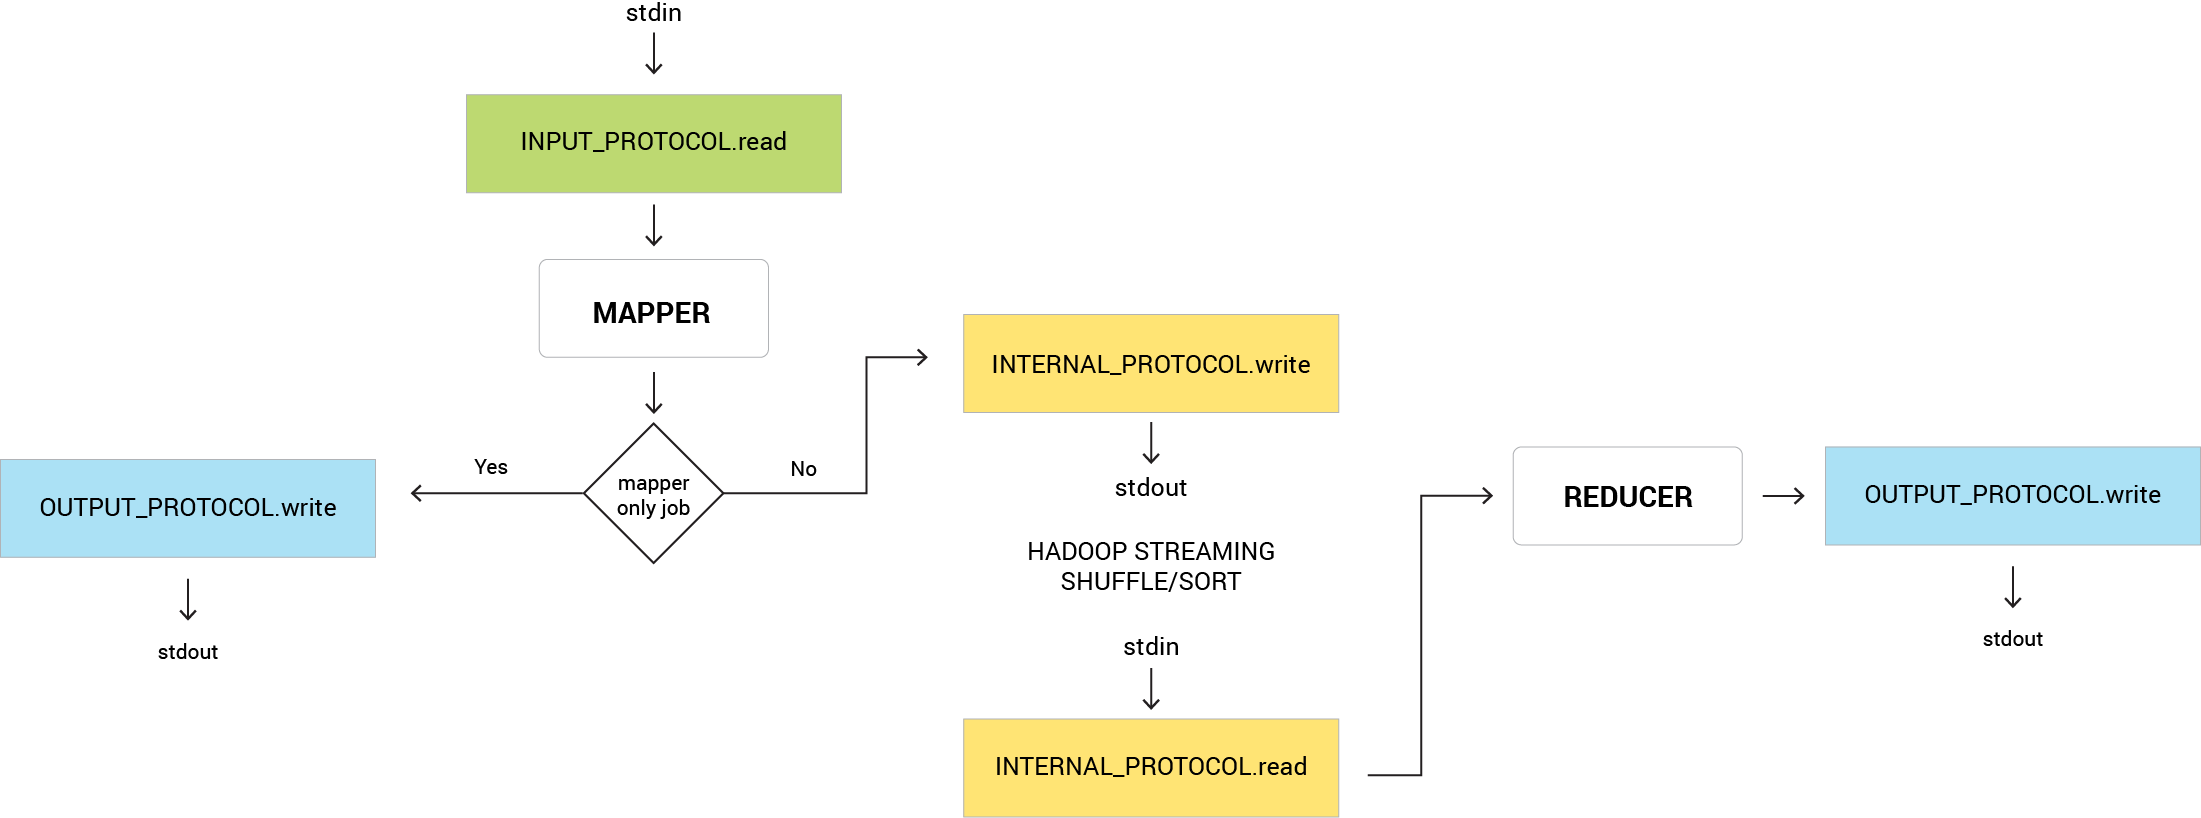

In [5]:
Image("protocols-io-3.png")

<h3><a name="MRJob-Protocols-role">Types of Built-in Protocols</a></h3>

MRJob provides a number of buildin protocols, which all can be used for INPUT_PROTOCOL, INTERNAL_PROTOCOL or OUTPUT_PROTOCOL. By default, MRJob uses `RawValueProtocol` for INPUT_PROTOCOL, and `JSONProtocol` for INTERNAL_PROTOCOL and OUTPUT_PROTOCOL.

The table below lists four commonly used Protocols and their signiture. Some key observations are:

1. RawProtocol and RawValueProtocol do not attempt to serialize and deserialize text data
2. JSONProtocol and JSONValueProtocol uses JSON encoder and decoder to convert between text (stdin/stdout) and python data structrues (python runtime)
3. Value Protocols always treat key as `None` and do not auto insert tab character in its write method

<table>
  <tr>
    <th></th>
    <th colspan="4">read</th>
    <th colspan="4">write</th>
  </tr>
  <tr>
    <td colspan="9" style="background:#f0f0f0; height:1.5em"></td>
  </tr>
  <tr>
    <td rowspan="5">RawProtocol</td>
    <td colspan="2" style="color:#fff;background:#464646">**Source**:  stdin</td>
    <td colspan="2">**Target**: python</td>
    <td colspan="2">**Source**: python</td>
    <td colspan="2" style="color:#fff;background:#464646">**Target**: stdout</td>
  </tr>
  <tr>
    <td style="background:#f0f0f0">**Type**</td>
    <td style="color:#fff;background:#464646">Text</td>
    <td style="background:#f0f0f0">**Type**</td>
    <td>tuple(str, str)</td>
    <td style="background:#f0f0f0">**Type**</td>
    <td>tuple(str, str)</td>
    <td style="background:#f0f0f0">**Type**</td>
    <td style="color:#fff;background:#464646">Text</td>
  </tr>
  <tr>
    <td style="background:#f0f0f0">**Shape**</td>
    <td style="color:#fff;background:#464646">{Key}  [TAB]  {Value}</td>
    <td style="background:#f0f0f0">**Shape**</td>
    <td>({Key}, {Value})</td>
    <td style="background:#f0f0f0">**Shape**</td>
    <td>({Key}, {Value})</td>
    <td style="background:#f0f0f0">**Shape**</td>
    <td style="color:#fff;background:#464646">{Key}  [TAB]  {Value}</td>
  </tr>
  <tr>
    <td rowspan="2" style="background:#f0f0f0">Examples</td>
    <td colspan="3">word    12  ⟶  ("word", "12")</td>
    <td rowspan="2" style="background:#f0f0f0">Examples</td>
    <td colspan="3">yield ("word", "12")  ⟶  word    12</td>
  </tr>
  <tr>
    <td colspan="3">line_with_no_tab  ⟶  <span style="color:red">raise ValueError</span></td>
    <td colspan="3">yield ("a\tb", "value")  ⟶  a     b    value</td>
  </tr>
  <tr>
    <td colspan="9" style="background:#f0f0f0; height:5em"></td>
  </tr>
  <tr>
    <td rowspan="5">RawValueProtocol</td>
    <td colspan="2" style="color:#fff;background:#464646">**Source**: stdin</td>
    <td colspan="2">**Target**: python</td>
    <td colspan="2">**Source**: python</td>
    <td colspan="2" style="color:#fff;background:#464646">**Target**: stdout</td>
  </tr>
  <tr>
    <td style="background:#f0f0f0">**Type**</td>
    <td style="color:#fff;background:#464646">Text</td>
    <td style="background:#f0f0f0">**Type**</td>
    <td>tuple(None, str)</td>
    <td style="background:#f0f0f0">**Type**</td>
    <td>tuple(\*, str)</td>
    <td style="background:#f0f0f0">**Type**</td>
    <td style="color:#fff;background:#464646">Text</td>
  </tr>
  <tr>
    <td style="background:#f0f0f0">**Shape**</td>
    <td style="color:#fff;background:#464646">{Value}</td>
    <td style="background:#f0f0f0">**Shape**</td>
    <td>(None, {Value})</td>
    <td style="background:#f0f0f0">**Shape**</td>
    <td>({}, {Value})</td>
    <td style="background:#f0f0f0">**Shape**</td>
    <td style="color:#fff;background:#464646">{Value}</td>
  </tr>
  <tr>
    <td rowspan="2" style="background:#f0f0f0">Examples</td>
    <td colspan="3">word    12  ⟶  (None, "word\t12")</td>
    <td rowspan="2" style="background:#f0f0f0">Examples</td>
    <td colspan="3">yield ("word", "12")  ⟶  12</td>
  </tr>
  <tr>
    <td colspan="3">line_with_no_tab  ⟶  (None, "line_with_no_tab")</td>
    <td colspan="3">yield (None, "a\tb")  ⟶  a    b</td>
  </tr>
  <tr>
    <td colspan="9" style="background:#f0f0f0; height:5em"></td>
  </tr>
  <tr>
    <td rowspan="5">JSONProtocol</td>
    <td colspan="2" style="color:#fff;background:#464646">**Source**: stdin</td>
    <td colspan="2">**Target**: python</td>
    <td colspan="2">**Source**: python</td>
    <td colspan="2" style="color:#fff;background:#464646">**Target**: stdout</td>
  </tr>
  <tr>
    <td style="background:#f0f0f0">**Type**</td>
    <td style="color:#fff;background:#464646">Text</td>
    <td style="background:#f0f0f0">**Type**</td>
    <td>tuple(\*, \*)</td>
    <td style="background:#f0f0f0">**Type**</td>
    <td>tuple(\*, \*)</td>
    <td style="background:#f0f0f0">**Type**</td>
    <td style="color:#fff;background:#464646">Text</td>
  </tr>
  <tr>
    <td style="background:#f0f0f0">**Shape**</td>
    <td style="color:#fff;background:#464646">{Key} [TAB] {Value}</td>
    <td style="background:#f0f0f0">**Shape**</td>
    <td>({Key}, {Value})</td>
    <td style="background:#f0f0f0">**Shape**</td>
    <td>({Key}, {Value})</td>
    <td style="background:#f0f0f0">**Shape**</td>
    <td style="color:#fff;background:#464646">{Key}  [TAB]  {Value}</td>
  </tr>
  <tr>
    <td rowspan="2" style="background:#f0f0f0">Examples</td>
    <td colspan="3">10    [1,true,null, "abc"]    ⟶    (10, [1,True,None, "abc"])</td>
    <td rowspan="2" style="background:#f0f0f0">Examples</td>
    <td colspan="3">yield ([1,2], [[1,"3"]])  ⟶ [1, 2]    [[1,"3"]]</td>
  </tr>
  <tr>
    <td colspan="3">line_with_no_tab    ⟶    (None, "line_with_no_tab")</td>
    <td colspan="3">yield 1, 2  ⟶  1    2</td>
  </tr>
  <tr>
    <td colspan="9" style="background:#f0f0f0; height:5em"></td>
  </tr>
  <tr>
    <td rowspan="5">JSONValueProtocol</td>
    <td colspan="2" style="color:#fff;background:#464646">**Source**: stdin</td>
    <td colspan="2">**Target**: python</td>
    <td colspan="2">**Source**: python</td>
    <td colspan="2" style="color:#fff;background:#464646">**Target**: stdout</td>
  </tr>
  <tr>
    <td style="background:#f0f0f0">**Type**</td>
    <td style="color:#fff;background:#464646">Text</td>
    <td style="background:#f0f0f0">**Type**</td>
    <td>tuple(\*, \*)</td>
    <td style="background:#f0f0f0">**Type**</td>
    <td>tuple(\*, \*)</td>
    <td style="background:#f0f0f0">**Type**</td>
    <td style="color:#fff;background:#464646">Text</td>
  </tr>
  <tr>
    <td style="background:#f0f0f0">**Shape**</td>
    <td style="color:#fff;background:#464646">{Value}</td>
    <td style="background:#f0f0f0">**Shape**</td>
    <td>(None, {Value})</td>
    <td style="background:#f0f0f0">**Shape**</td>
    <td>({}, {Value})</td>
    <td style="background:#f0f0f0">**Shape**</td>
    <td style="color:#fff;background:#464646">{Value}</td>
  </tr>
  <tr>
    <td rowspan="2" style="background:#f0f0f0">Examples</td>
    <td colspan="3">10    [1,true,null, "abc"] ⟶ <span style="color:red">raise ValueError</span></td>
    <td rowspan="2" style="background:#f0f0f0">Examples</td>
    <td colspan="3">yield (1, {2:3})  ⟶  {"2":3}</td>
  </tr>
  <tr>
    <td colspan="3">{"value": { "nested":[1]}} ⟶ (None, {"value": { "nested":[1]}})</td>
    <td colspan="3">yield ([1,2,3], {"value":10}) ⟶  {"value":10}</td>
  </tr>
  <tr>
    <td colspan="9" style="background:#f0f0f0; height:1.5em"></td>
  </tr>
</table>

The following example further illustrates the behaviors of these protocols. 

In this simplified example, a single line or text input (single line text file containing: `1001    {"value":10}`) is fed to four different single step mapreduce jobs. Each uses one of the four Protocols discussed above as INPUT_PROTOCOL, INTERNAL_PROTOCOL and OUTPUT_PROTOCOL.

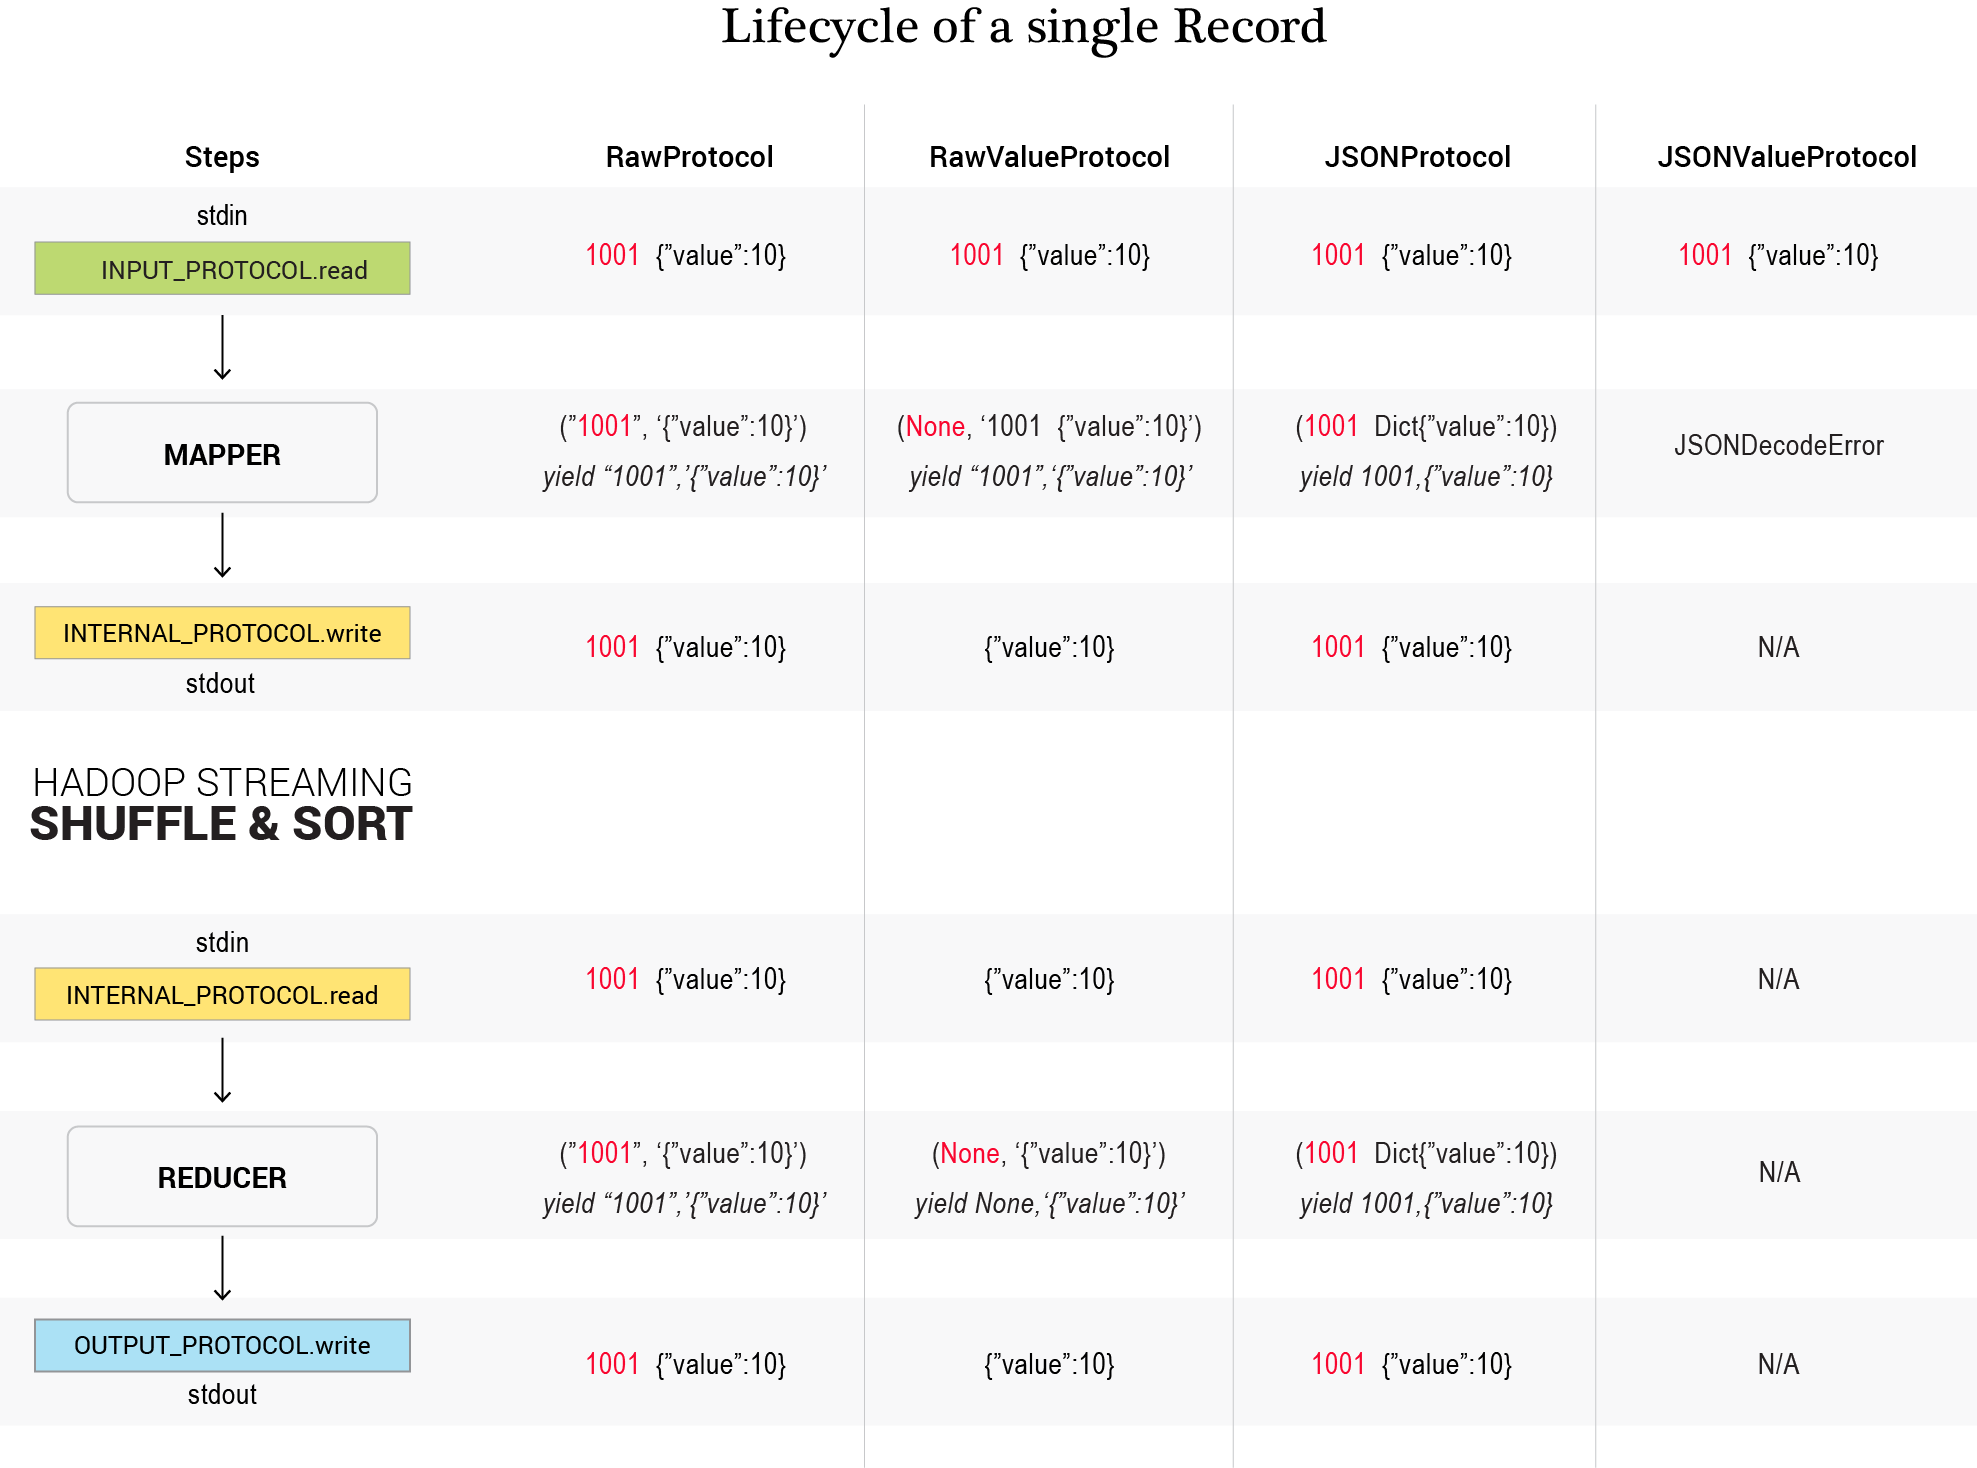

In [8]:
Image("record-lifecyle-3.png")

In [17]:
%%writefile raw_protocol.py

from mrjob.job import MRJob
from mrjob.protocol import RawProtocol

class RawProtocolExample(MRJob):
  
    INPUT_PROTOCOL = RawProtocol
    OUTPUT_PROTOCOL = RawProtocol
    INTERNAL_PROTOCOL = RawProtocol
    
    def mapper(self, key, value):
        assert key == "1001"
        assert value == "{\"value\":10}"
        yield "1001", "{\"value\":10}"
    def reducer(self, key, values):
        for value in values:
            assert key == "1001"
            assert value == "{\"value\":10}"
            yield "1001", "{\"value\":10}"

if __name__ == '__main__':
    RawProtocolExample.run()

Writing raw_protocol.py


In [25]:
!echo '1001\t{"value":10}' | python raw_protocol.py

No configs found; falling back on auto-configuration
Creating temp directory /tmp/raw_protocol.yiran.20160828.061913.768951
Running step 1 of 1...
reading from STDIN
Streaming final output from /tmp/raw_protocol.yiran.20160828.061913.768951/output...
1001	{"value":10}
Removing temp directory /tmp/raw_protocol.yiran.20160828.061913.768951...


In [26]:
%%writefile raw_value_protocol.py

from mrjob.job import MRJob
from mrjob.protocol import RawValueProtocol

class RawValueProtocolExample(MRJob):
  
    INPUT_PROTOCOL = RawValueProtocol
    OUTPUT_PROTOCOL = RawValueProtocol
    INTERNAL_PROTOCOL = RawValueProtocol
    
    def mapper(self, key, value):
        assert key == None
        assert value == "1001\t{\"value\":10}"
        yield "1001", "{\"value\":10}"
    def reducer(self, key, values):
        for value in values:
            assert key == None
            assert value == "{\"value\":10}"
            yield None, "{\"value\":10}"

if __name__ == '__main__':
    RawValueProtocolExample.run()

Overwriting raw_value_protocol.py


In [27]:
!echo '1001\t{"value":10}' | python raw_value_protocol.py

No configs found; falling back on auto-configuration
Creating temp directory /tmp/raw_value_protocol.yiran.20160828.061937.666190
Running step 1 of 1...
reading from STDIN
Streaming final output from /tmp/raw_value_protocol.yiran.20160828.061937.666190/output...
{"value":10}
Removing temp directory /tmp/raw_value_protocol.yiran.20160828.061937.666190...


In [20]:
%%writefile json_protocol.py

from mrjob.job import MRJob
from mrjob.protocol import JSONProtocol

class JSONProtocolExample(MRJob):
  
    INPUT_PROTOCOL = JSONProtocol
    OUTPUT_PROTOCOL = JSONProtocol
    INTERNAL_PROTOCOL = JSONProtocol
    
    def mapper(self, key, value):
        assert key == 1001
        assert value == {"value":10}
        assert isinstance(value, dict)
        yield key, value
    def reducer(self, key, values):
        for value in values:
            assert key == 1001
            assert value == {"value":10}
            yield key, value

if __name__ == '__main__':
    JSONProtocolExample.run()

Writing json_protocol.py


In [28]:
!echo '1001\t{"value":10}' | python json_protocol.py

No configs found; falling back on auto-configuration
Creating temp directory /tmp/json_protocol.yiran.20160828.061950.622934
Running step 1 of 1...
reading from STDIN
Streaming final output from /tmp/json_protocol.yiran.20160828.061950.622934/output...
1001	{"value":10}
Removing temp directory /tmp/json_protocol.yiran.20160828.061950.622934...


In [21]:
%%writefile json_value_protocol.py

from mrjob.job import MRJob
from mrjob.protocol import JSONValueProtocol

class JSONValueProtocolExample(MRJob):
  
    INPUT_PROTOCOL = JSONValueProtocol
    OUTPUT_PROTOCOL = JSONValueProtocol
    INTERNAL_PROTOCOL = JSONValueProtocol
    
    def mapper(self, key, value):
        pass
    def reducer(self, key, values):
        pass

if __name__ == '__main__':
    JSONValueProtocolExample.run()

Writing json_value_protocol.py


In [33]:
!echo '1001\t{"value":10}' | python json_value_protocol.py 2>&1 | tail -1

ValueError: Trailing data


### Importance of RawProtocols in Context of Total Sorting

While working with MRJob it's critical to understand it's an abstraction layer _above_ hadoop streaming, and does not extend or modify hadoop streaming's normal behaviors. Hadoop streaming works through unix piping, and uses `stdout` and `stderr` as communication channels. In unix environments, the protocol of data transfer is text streams, mappers, reducers and hadoop libraries exchange data all through texts. 

Therefore, data structures common in programming languages (eg. dictionary in python) has to serialized to text for hadoop streaming to understand and consume. The implication of this on total sorting is this: since hadoop only sees texts, custom data structures (as keys) will be sorted as strings in their serialized forms.

MRJob abstract away data serialization and deserialization process by the concept of protocols. For instance, `JSONProtocol` is capable of serializing complex data structures, and is used by default as INTERNAL_PROTOCOL. This frees the user from messing string manipulation and processing, but it does come with a cost. 

One example is python tuples:

```
# mapper
yield 1, ("value", "as", "tuple", True)

```

Inside reducer however, when values are deserialized into python objects, the key, value pair above will become:
```
1, ["value", "as", "tuple", True]

```

Namely, tuples become lists, due to the fact JSON does not support tuples. 

Another example related to sorting, suppose mappers emit custom data structures as composite keys, such as:
```
# mapper
yield [12, 1, 2016]
```

Assume we want to use hadoop streaming's `KeyFieldBasedComparator`, when hadoop streaming sees JSON string `[2016, 12, 1]`, it is very difficult to instruct hadoop to understand the key consists three field (month, day, year), and sort them accordingly (eg. we want sort by year, month, day).

Notice if we yield a date as `[2016, 12, 01]` instead, the string comparison coincidentally produce the same sort order as the underlying data (dates). However, to to achieve this requires intimate knowledge of JSON (or other transportation format), therefore, we recommand to use `RawProtocol` or `RawValueProtocol` when advanced sorting is desired, which offers maximum flexibility to control key sorting and key hashing performed by hadoop streaming.

<h2><a name="MRJob-partitioning">III.C. Partitioning in MRJob</a></h2>
<a href="#Section3">Back to Section 3</a>  |  <a href="#top">Back to top</a>   
<h4>Keypoints:</h4>

<ul>
<li>Challenge: which partition contains the largest/smallest values seems arbitrary</li>
<li>Hadoop streaming `KeyFieldBasedPartitioner` does not sort partition keys, even though it seemingly accepts unix `sort` compatible configurations</li>
<li>MRJob uses Hadoop Streaming under the hood, therefore inherits the same problem</li>
</ul>

<h4>Solution:</h4>

<ul>
<li>Understand the inner working of `HashPartitioner` and `KeyFieldBasedPartitioner`</li>
<li>Relationship between `KeyFieldBasedPartitioner` and `HashPartitioner`:   

  * `KeyFieldBasedPartitioner` applies `HashPartitioner` on configured key field(s)</li>
  
<li>Create the inverse function of `HashPartitioner` and assign partition keys accordingly</li>
</ul>

<a name="illustration"></a>The following graphic illustrates the steps we'll take:

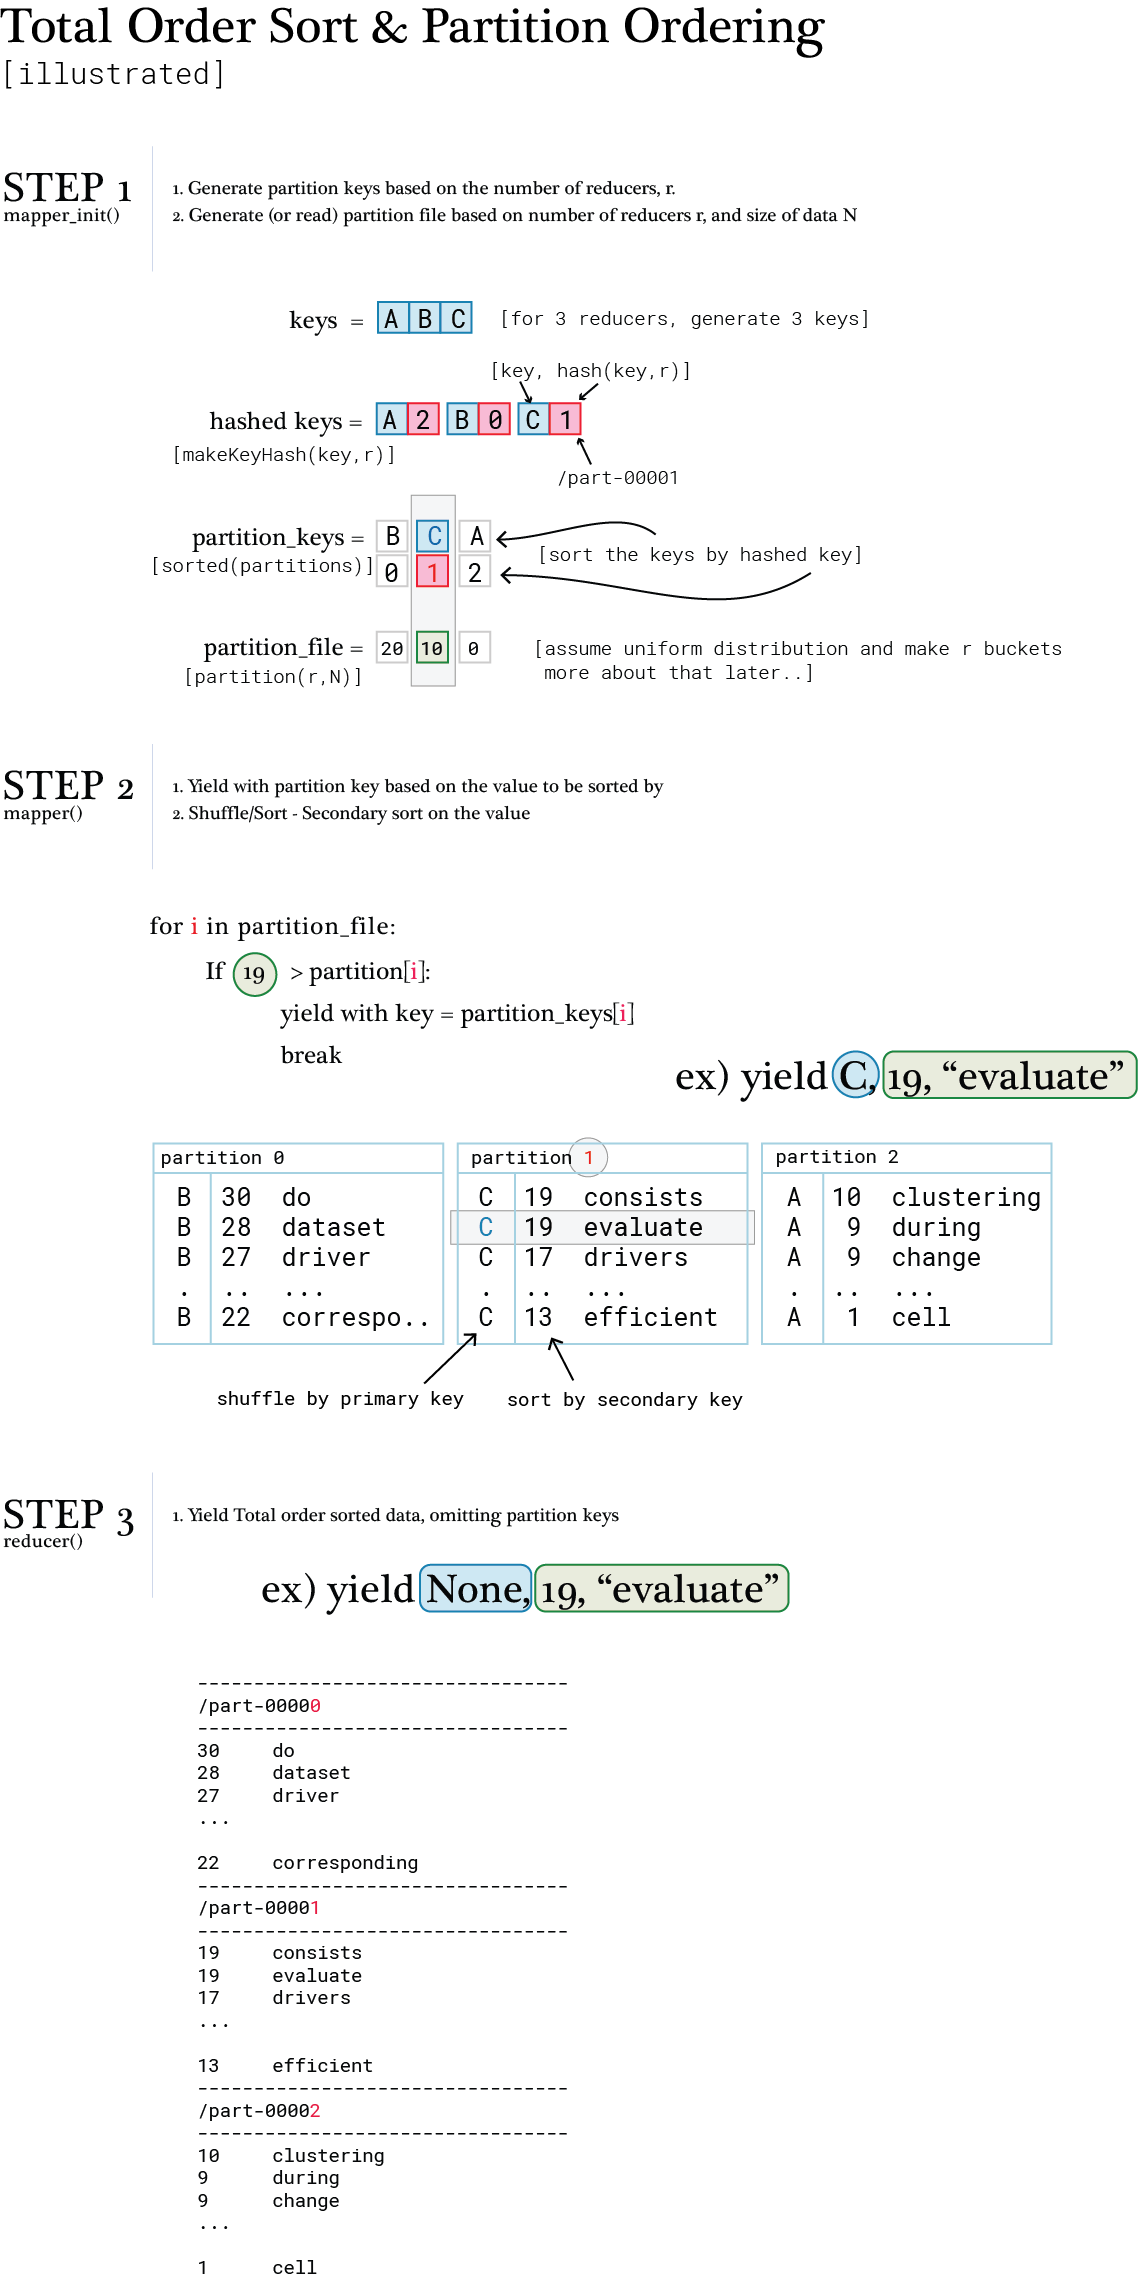

In [66]:
from IPython.display import Image
Image(filename="total-order-sort-V2.png")

#### Understanding HashPartitioner

By default, Hadoop uses a library class `HashPartitioner` to compute partition index for keys produced by mappers. It has a method called `getPartition`, which takes `key.hashCode() & Integer.MAX_VALUE` and finds the modulus using the number of reduce tasks. For example, if there are 10 reduce tasks, getPartition will return values 0 through 9 for all keys.

```
// HashPartitioner

partitionIndex = (key.hashCode() & Integer.MAX_VALUE) % numReducers
```

In the land of native hadoop applications (written in `java` or `jvm` languages), keys can be any object type that is hashable (implements hashable interface). For hadoop streaming, however, keys are always string values. Therefore the hashCode function for strings are used:

```
public int hashCode() {
    int h = hash;
    if (h == 0 && value.length > 0) {
        char val[] = value;

        for (int i = 0; i < value.length; i++) {
            h = 31 * h + val[i];
        }
        hash = h;
    }
    return h;
}
```

When we configure hadoop streaming to use `KeyBasedPartitioner`, the process is very similar. Hadoop streaming will parse command line options such as `-k2,2` in to key specs, and extract the part of composite keys (in this example, field 2 of many fields) and read in the partition key as strings. For example, with the following configuration:

```
"stream.map.output.field.separator" : ".",
"mapreduce.partition.keycomparator.options": "-k2,2",
```

Hadoop will extract **a** from a composite key **2.a.4** to use as partition key.

The partition key then is hashed (as string) by the same `hashCode` function, it modulus using number of reduce tasks yields the partition index.

See `KeyBasedPartitioner` [source code](https://github.com/apache/hadoop/blob/2e1d0ff4e901b8313c8d71869735b94ed8bc40a0/hadoop-mapreduce-project/hadoop-mapreduce-client/hadoop-mapreduce-client-core/src/main/java/org/apache/hadoop/mapreduce/lib/partition/KeyFieldBasedPartitioner.java) for the actual implementations.

#### Inverse HashCode Function

In order to preserve partition key's ordering, we will construct a "inverse hashCode function". Which takes desired partition index and total number of partitions, to produce a partition key. This key when supplied to hadoop framework (KeyBasedPartitioner), will hash to correct partition index.

First, let's implement the core of `HashPartitioner` in python:

In [7]:
def makeKeyHash(key, num_reducers):
    byteof = lambda char: int(format(ord(char), 'b'), 2)
    current_hash = 0
    for c in key:
        current_hash = (current_hash * 31 + byteof(c))
    return current_hash % num_reducers

# partition indices for keys: a,b,c,d,e; with 5 partitions
[makeKeyHash(x, 5) for x in "abcde"]

[2, 3, 4, 0, 1]

A simple strategy to implement a inverse hashCode function is to use a lookup table. For example, assume we have 5 reducers, we can compute the partition index with `makeKeyHash` for keys "a", "b", "c", "d" and "e". Results are listed the the table below.

| **Partition Key** | **Partition Index** |
|-------------------|---------------------|
| a                 | 2                   |
| b                 | 3                   |
| c                 | 4                   |
| d                 | 0                   |
| e                 | 1                   |

In mapper stage, if we want to assign a record to partition 0 for example, we can simply look the partition key that generated the partition index 0, which in this case is "d". 

<h2><a name="MRJOB-implementation">III.D. MRJob Implementations</a></h2>
<a href="#Section3">Back to Section 3</a>  |  <a href="#top">Back to top</a>    

<h3>III.D.1 MRJob implementation - single reducer - local mode</h3>
(Included only for completeness)

In [152]:
%%writefile singleReducerSortLocal.py

import sys
import mrjob
from mrjob.job import MRJob
from mrjob.step import MRStep

class singleReducerSortLocal(MRJob):
        
    def mapper(self, _, line):
        line = line.strip()
        key,value = line.split('\t')
        yield (sys.maxint - int(key)), value

    def reducer(self, key, value):
        for v in value:
            yield sys.maxint - key, v
        
    def steps(self):
        return [MRStep(
                    mapper=self.mapper,
                    reducer=self.reducer)
                ]

if __name__ == '__main__':
    singleReducerSortLocal.run()

Overwriting singleReducerSortLocal.py


In [155]:
!python singleReducerSortLocal.py generate_numbers.output > MRJob_singleReducer_local_sorted_output.txt

In [154]:
!cat MRJob_singleReducer_local_sorted_output.txt

30	"do"
28	"dataset"
27	"creating"
27	"driver"
27	"experiements"
26	"def"
26	"descent"
25	"compute"
24	"code"
24	"done"
23	"descent"
22	"corresponding"
19	"consists"
19	"evaluate"
17	"drivers"
15	"computational"
15	"computing"
15	"document"
14	"center"
13	"efficient"
10	"clustering"
9	"change"
9	"during"
7	"contour"
5	"distributed"
4	"develop"
3	"different"
2	"cluster"
1	"cell"
0	"current"


<h3>III.D.2. MRJob implementation - single reducer - hadoop mode</h3>
No need for any special paritioning, but can be a bottle neck when data is large

In [60]:
%%writefile singleReducerSort.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-
import mrjob
from mrjob.job import MRJob
from mrjob.step import MRStep

class singleReducerSort(MRJob):
    # By specifying sort values True, mrjob will do a secondary sort on the value, in this case the words.
    # ties will be broken by sorting words alphabetically in ascending order
    MRJob.SORT_VALUES = True   
    
    def mapper(self, _, line):
        line = line.strip()
        key,value = line.split('\t')
        yield int(key),value

    def reducer(self, key, value):
        for v in value:
            yield key, v
        
    def steps(self):
        JOBCONF_STEP = {
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'stream.map.output.field.separator':'\t',    
            'mapreduce.partition.keycomparator.options': '-k1,1nr -k2',
            'mapreduce.job.reduces': '1'
        }
        return [MRStep(jobconf=JOBCONF_STEP,
                    mapper=self.mapper,
                    reducer=self.reducer)
                ]

if __name__ == '__main__':
    singleReducerSort.run()

Overwriting singleReducerSort.py


In [134]:
!python singleReducerSort.py -r hadoop generate_numbers.output > MRJob_singleReducer_sorted_output.txt

In [34]:
print "="*100
print "Single Reducer Sorted Output - MRJob"
print "="*100
!cat MRJob_singleReducer_sorted_output.txt

Single Reducer Sorted Output - MRJob
30	"do"
28	"dataset"
27	"creating"
27	"driver"
27	"experiements"
26	"def"
26	"descent"
25	"compute"
24	"code"
24	"done"
23	"descent"
22	"corresponding"
19	"consists"
19	"evaluate"
17	"drivers"
15	"computational"
15	"computing"
15	"document"
14	"center"
13	"efficient"
10	"clustering"
9	"change"
9	"during"
7	"contour"
5	"distributed"
4	"develop"
3	"different"
2	"cluster"
1	"cell"
0	"current"


<h3>III.D.3. MRJob Multiple Reducers - With Un-Ordered Partitons</h3>
The equivalent of the Hadoop Streaming Total Order Sort implementation above

In [67]:
%%writefile MRJob_unorderedTotalOrderSort.py

import mrjob
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import RawValueProtocol
from mrjob.protocol import RawProtocol
from operator import itemgetter
import numpy as np

class MRJob_unorderedTotalOrderSort(MRJob):
    
    # The following three settings are your sorting best friends:
    MRJob.SORT_VALUES = True 
    
    # The protocols are critical. It will not work without these:
    INTERNAL_PROTOCOL = RawProtocol
    OUTPUT_PROTOCOL = RawProtocol
 
    def __init__(self, *args, **kwargs):
        super(MRJob_unorderedTotalOrderSort, self).__init__(*args, **kwargs)
        self.N = 30
        self.NUM_REDUCERS = 3
    
    
    def mapper(self, _, line):
        line = line.strip()
        key,value = line.split('\t')
        if int(key) > 20:
            yield "A", key+"\t"+value
        elif int(key) > 10:
            yield "B", key+"\t"+value
        else:
            yield "C", key+"\t"+value
            
    def reducer(self,key,value):
        for v in value:
            yield key,v

    
    def steps(self):
        
        JOBCONF_STEP1 = {
            'stream.num.map.output.key.field':2,
            'stream.map.output.field.separator':"\t",
            'mapreduce.partition.keypartitioner.options':'-k1,1',
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'mapreduce.partition.keycomparator.options':'-k2,2nr -k3',
            'mapred.reduce.tasks': self.NUM_REDUCERS,
            'partitioner':'org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner'
        }
        return [MRStep(jobconf=JOBCONF_STEP1,
                    mapper=self.mapper,
                    reducer=self.reducer)
                ]

if __name__ == '__main__':
    MRJob_unorderedTotalOrderSort.run()

Overwriting MRJob_unorderedTotalOrderSort.py


In [135]:
!hdfs dfs -rmr /user/koza/sort/un_output 
!python MRJob_unorderedTotalOrderSort.py  -r hadoop generate_numbers.output \
    --output-dir=/user/koza/sort/un_output 

In [36]:
!hdfs dfs -ls /user/koza/sort/un_output 

Found 4 items
-rw-r--r--   1 koza supergroup          0 2016-08-20 19:28 /user/koza/sort/un_output/_SUCCESS
-rw-r--r--   1 koza supergroup        116 2016-08-20 19:28 /user/koza/sort/un_output/part-00000
-rw-r--r--   1 koza supergroup        125 2016-08-20 19:28 /user/koza/sort/un_output/part-00001
-rw-r--r--   1 koza supergroup        152 2016-08-20 19:28 /user/koza/sort/un_output/part-00002


### Without special partitioning, the output is not organized by partition number.
(i.e., part-00000 does not contain the "A" key)

In [37]:
print "----/part-00000-----\n"
!hdfs dfs -cat /user/koza/sort/un_output/part-00000
print "\n----/part-00001-----\n"
!hdfs dfs -cat /user/koza/sort/un_output/part-00001
print "\n----/part-00001-----\n"
!hdfs dfs -cat /user/koza/sort/un_output/part-00002

----/part-00000-----

B	19	consists
B	19	evaluate
B	17	drivers
B	15	computing
B	15	document
B	15	computational
B	14	center
B	13	efficient

----/part-00001-----

C	10	clustering
C	9	during
C	9	change
C	7	contour
C	5	distributed
C	4	develop
C	3	different
C	2	cluster
C	1	cell
C	0	current

----/part-00001-----

A	30	do
A	28	dataset
A	27	driver
A	27	creating
A	27	experiements
A	26	descent
A	26	def
A	25	compute
A	24	done
A	24	code
A	23	descent
A	22	corresponding


<h3>III.D.4. MRJob Multiple Reducers - With Ordered Partitons</h3>
The final Total Order Sort with ordered partitions

#### What's New

The solution we will delve into is very similar to the one discussed earlier in [hadoop streaming](#multiple-reducer-hadoop-streaming) section. The only addition is _Step 1B_, where we take a desired partition index, and craft a custom partition key such that hadoop's KeyFieldBasedPartitioner hashes it back to the correct index.

In [6]:
Image("TotalSortStepsComplete.png")

In [72]:
%%writefile MRJob_multipleReducerTotalOrderSort.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

import mrjob
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import RawValueProtocol
from mrjob.protocol import RawProtocol
from operator import itemgetter
import numpy as np

class MRJob_multipleReducerTotalOrderSort(MRJob):
    
    # The following three settings are your sorting best friends:
    MRJob.SORT_VALUES = True 
    
    # The protocols are critical. It will not work without these:
    INTERNAL_PROTOCOL = RawProtocol
    OUTPUT_PROTOCOL = RawProtocol
 
    def __init__(self, *args, **kwargs):
        super(MRJob_multipleReducerTotalOrderSort, self).__init__(*args, **kwargs)
        self.N = 30
        self.NUM_REDUCERS = 3
    
    def mapper_partitioner_init(self):
        
        def makeKeyHash(key, num_reducers):
            byteof = lambda char: int(format(ord(char), 'b'), 2)
            current_hash = 0
            for c in key:
                current_hash = (current_hash * 31 + byteof(c))
            return current_hash % num_reducers
        
        # printable ascii characters, starting with 'A'
        keys = [str(unichr(i)) for i in range(65,65+self.NUM_REDUCERS)]
        partitions = []
        
        for key in keys:
            partitions.append([key, makeKeyHash(key, self.NUM_REDUCERS)])

        parts = sorted(partitions,key=itemgetter(1))
        self.partition_keys = list(np.array(parts)[:,0])
        
        self.partition_file = np.arange(0,self.N,self.N/(self.NUM_REDUCERS))[::-1]
        
    def mapper_partition(self, _, line):
        line = line.strip()
        key,value = line.split('\t')
        
        # Prepend the approriate key by finding the bucket, and using the index to fetch the key.
        for idx in xrange(self.NUM_REDUCERS):
            if float(key) > self.partition_file[idx]:
                yield str(self.partition_keys[idx]),key+"\t"+value
                break
        
        
            
    def reducer(self,key,value):
        for v in value:
            yield key,v
            # To omit the partition key, specify 'None'
            # We are keeping it for illutration purposes
    
    def steps(self):
        
        JOBCONF_STEP1 = {
            'stream.num.map.output.key.field':3,
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'stream.map.output.field.separator':"\t",
            'mapreduce.partition.keypartitioner.options':'-k1,1',
            'mapreduce.partition.keycomparator.options':'-k2,2nr -k3,3',
            'mapred.reduce.tasks': self.NUM_REDUCERS,
            'partitioner':'org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner'
        }
        return [MRStep(jobconf=JOBCONF_STEP1,
                    mapper_init=self.mapper_partitioner_init,
                    mapper=self.mapper_partition,
                    reducer=self.reducer)
                ]


if __name__ == '__main__':
    MRJob_multipleReducerTotalOrderSort.run()

Overwriting MRJob_multipleReducerTotalOrderSort.py


In [136]:
!hdfs dfs -rm -r /user/koza/total_order_sort
!python MRJob_multipleReducerTotalOrderSort.py -r hadoop generate_numbers.output \
    --output-dir='/user/koza/total_order_sort' 

In [39]:
print "="*100
print "Total Order Sort with multiple reducers - notice that the part files are also in order."
print "="*100
print "/part-00000"
print "-"*100
!hdfs dfs -cat /user/koza/total_order_sort/part-00000
print "-"*100
print "/part-00001"
print "-"*100
!hdfs dfs -cat /user/koza/total_order_sort/part-00001
print "-"*100
print "/part-00002"
print "-"*100
!hdfs dfs -cat /user/koza/total_order_sort/part-00002


Total Order Sort with multiple reducers - notice that the part files are also in order.
/part-00000
----------------------------------------------------------------------------------------------------
B	30	do
B	28	dataset
B	27	driver
B	27	creating
B	27	experiements
B	26	def
B	26	descent
B	25	compute
B	24	done
B	24	code
B	23	descent
B	22	corresponding
----------------------------------------------------------------------------------------------------
/part-00001
----------------------------------------------------------------------------------------------------
C	19	consists
C	19	evaluate
C	17	drivers
C	15	computing
C	15	document
C	15	computational
C	14	center
C	13	efficient
----------------------------------------------------------------------------------------------------
/part-00002
----------------------------------------------------------------------------------------------------
A	10	clustering
A	9	during
A	9	change
A	7	contour
A	5	distributed
A	4	develop
A	3	different
A	2	cluster

<a name="illustration"></a>

<h3>Total Order Sort results</h3>
We now have exactly what we were looking for. Total Order Sort, with the added benefit of ordered partitions. Notice that the top results are stored in part-00000, the next set of results is stored in part-00001, etc., because we hashed the keys (A,B,C) to those file names.

<h1><a name="Section4">Section IV - Sampling Key Spaces</a></h1>
<a href="#top">Back to top</a>   

<h4>Keypoints:</h4>
<ul>
<li>Random Sampling - Easy implementation when we know the total size of the data</li>
<li>Reservoir Sampling - A method to sample the data with equal probablity for all data points when the size of the data is unknown. The algorithm works as follows:
    <pre>
    n = desired sample size
    reservoir = []
    for d in data
        if reservoir size < n
            add d to reservoir
        else:
            choose random location in reservoir
            flip coin whether to replace the exisiting d with new d
    </pre>
    
    This paper has a nice explanation of reservoir sampling, see: 2.2 Density-Biased Reservoir Sampling
    http://science.sut.ac.th/mathematics/pairote/uploadfiles/weightedkm-temp2_EB.pdf
</li>
</ul>
<p>
In the example we assumed a uniform distribution of the data. For simplicity, we made our partition file based on that assumption. In reality this is rarely the case, and we should make our partition file based on the actual distribution of the data to avoid bottle necks. A bottle neck would occur if the majority of our data resided in a single bucket, as could happen with a typical power law distribution. 
</p>

Consider the following example:

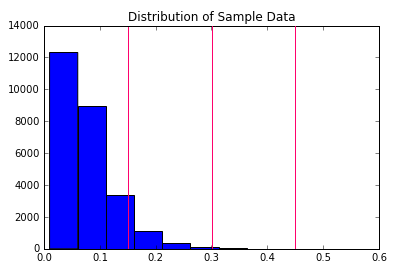

In [146]:
from IPython.display import Image
Image(filename="uniform-partitions.png")

If we made a uniform partition file (above example has 4 buckets), we would end up with most of the data in a single reducer, and this would create a bottle neck. To fix this, we must first generate a sample our data, then based on this sample create a partition file that distributes the keys more evenly.

<h2>IV.A. Random Sample implementation</h2>

In [36]:
%%writefile MRJob_RandomSample.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

#########################################################
#  Emit a random sample of 1/1000th of the data
#########################################################


import numpy as np
import mrjob
from mrjob.job import MRJob
from mrjob.step import MRStep

class MRbuildSample(MRJob):
    
    def steps(self):
        return [MRStep(mapper=self.mapper)]
    
    def mapper(self,_,line):
        s = np.random.uniform(0,1)
        if s < .001: 
            yield None, line

    
if __name__ == '__main__':
    MRJob_RandomSample.run()

Overwriting MRJob_RandomSample.py


<h2>IV.B. Custom partition file implementation</h2>

### Percentile Based Partitioning

Once we have a (small) sampled subset of data, we can compute partition boundaries by examine sample distribution and of the subset, and find approporiate percentiles based on number of desired partitions. A basic implementation using numpy is provided below:

In [22]:
def readSampleData():
    # A sample of the data is stored in a single file in sampleData/part-00000
    # from the previous step (MRJob_RandomSample.py)
    sampleData = []  

    with open("sampleData/part-00000","r") as f:
        lines = f.readlines()
        for line in lines:
            line = line.strip()
            avg,lisst = line.split("\t")
            sampleData.append(float(avg))
            
    return sampleData

In [23]:
from numpy import array, percentile, linspace, random

def partition(data, num_of_partitions=10, return_percentiles=False):
    # remove percentile 100
    qs = linspace(0, 100, num=num_of_partitions, endpoint=False)
    if not return_percentiles:
        return percentile(data, qs)
    return percentile(data, qs), qs

sampleData = readSampleData()

# (partitionFile, percentiles)
partition(sampleData, 4, return_percentiles=True)

(array([ 0.00986008,  0.04131517,  0.06350346,  0.09810477]),
 array([  0.,  25.,  50.,  75.]))

** Raw implementation without using `numpy` **

In [28]:
## MAKE % BASED BUCKETS FROM SAMPLE DATA
from __future__ import division
from math import ceil

sampleData = readSampleData()

num_buckets = 4 # This will be the number of reducers
len_data = len(sampleData)

# make breakpoints:
partitionFile = []

i = 0
while i < len_data:
    partitionFile.append(sampleData[i])
    i += int(ceil(len_data/num_buckets))

** Visualize Partition **

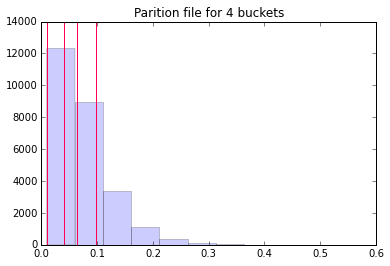

Sample Data min 0.00986007565667
Sample Data max 0.514811335171
[0.009860075656665268, 0.04131516964443623, 0.06350346288221721, 0.0981047679070244]


In [27]:
# Visualizae Partition File
import pylab as pl
pl.hist(sampleData, alpha=0.2)

xcoords = partitionFile
for xc in xcoords:
    pl.axvline(x=xc,color="#ff0055")


pl.title("Parition file for "+str(num_buckets)+" buckets")
pl.show()

print "Sample Data min", min(sampleData)
print "Sample Data max", max(sampleData)
print partitionFile

We can now replace the dynamilcally generated partition file (`self.partition_file`) in the `mapper_partitioner_init` function, with the custom file we just made.

<h1><a name="Section5">Section V - Spark implementation</a></h1>
<a href="#top">Back to top</a>   

For this section, you will need to install Spark. We are using a local installation, version 1.6

In [41]:
# Start Spark
import os
import sys
spark_home = os.environ['SPARK_HOME'] = \
   '/usr/local/share/spark-1.6.0-bin-hadoop2.6'

if not spark_home:
    raise ValueError('SPARK_HOME enviroment variable is not set')
sys.path.insert(0,os.path.join(spark_home,'python'))
sys.path.insert(0,os.path.join(spark_home,'python/lib/py4j-0.8.2.1-src.zip'))
execfile(os.path.join(spark_home,'python/pyspark/shell.py'))
app_name = "total-sort"
    
master = "local[*]"
conf = pyspark.SparkConf().setAppName(app_name).setMaster(master)
# print sc
# print sqlContext


Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 1.6.0
      /_/

Using Python version 2.7.11 (default, Dec  6 2015 18:57:58)
SparkContext available as sc, HiveContext available as sqlContext.


In [143]:
from operator import itemgetter
import numpy as np

text_file = sc.textFile('generate_numbers.output')
NUM_REDUCERS = 3

        
def top_down(x):
    if x[0] > 20:
        return 0
    elif x[0] > 10:
        return 1
    else:
        return 2
    
    
def readData(line):
    x = line.split("\t")
    return [int(x[0]),x[1]],""

rdd = text_file.map(readData)


'''
repartitionAndSortWithinPartitions(numPartitions=None, partitionFunc=<function portable_hash at 0x7f2bec385230>, ascending=True, keyfunc=<function <lambda> at 0x7f2bec3839b0>)
Repartition the RDD according to the given partitioner and, within each resulting partition, sort records by their keys.

By using this function we avoid unnecessary shuffling. In contrast, the sortByKey function reshuffles all the data and is not efficient.
'''
top = rdd.repartitionAndSortWithinPartitions(numPartitions=NUM_REDUCERS,
                                                    ascending=True, 
                                                    partitionFunc=top_down,
                                                    keyfunc=lambda x: (-x[0],x[1]))

In [144]:
# sortedRDD = rdd.sortByKey(keyfunc=lambda x: (-x[0],x[1]),ascending=True,numPartitions=3)
# ^^ inefficient sortByKey shuffles all the data

By using glom we can see each partition in its own array. We also have a secondary sort on the "word" (in fact this is the latter part of a complex key) in ascending order.

In [145]:
print top.getNumPartitions(), "Partitions"
for i,d in enumerate(top.glom().collect()):
    print "="*50
    print "partition ",i
    print "="*50
    for j in d:
        print j[0][0],"\t",j[0][1]

3 Partitions
partition  0
30 	do
28 	dataset
27 	creating
27 	driver
27 	experiements
26 	def
26 	descent
25 	compute
24 	code
24 	done
23 	descent
22 	corresponding
partition  1
19 	consists
19 	evaluate
17 	drivers
15 	computational
15 	computing
15 	document
14 	center
13 	efficient
partition  2
10 	clustering
9 	change
9 	during
7 	contour
5 	distributed
4 	develop
3 	different
2 	cluster
1 	cell
0 	current


<h1> Final Remarks</h1>
<a href="#top">Back to top</a>   

Note on `TotalSortPartitioner`:

- Hadoop has built in `TotalSortPartitioner`, which uses a partition file `_partition.lst` to store a pre-built order list of split points. `TotalSortPartitioner` uses binary search / Trie to look up the ranges a given record falls into. (try this out and provide examples applied to Hadoop streaming and MRJob if possible ... not sure about that).

https://github.com/facebookarchive/hadoop-20/blob/master/src/mapred/org/apache/hadoop/mapred/lib/TotalOrderPartitioner.java

# References
<a href="#top">Back to top</a>   

TODO: collect links/citations